# Práctica de Machine Learning: José Carlos Amo Pérez

Enero 2023

**OBJETIVO DE LA PRÁCTICA**

<font color="blue">A partir de un dataset extraído de Airbnb mediante técnicas de scraping, se pide predecir el precio del airbnb utilizando los datos
disponibles.</font>

<font color="red">TAREA 0. Cargo las librerías necesarias</font>

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import math
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor



import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

<font color="red">TAREA 1. Descargo el dataset y preparo los datos: División train/test.</font>
    
**Decido que todas las transformaciones, incluidas las obviedades como quitar los registros que no sean de madrid las voy a hacer una vez dividido en train y test.**

In [2]:
#ESTO GENERA UN CSV DE TRAIN Y UN CSV DE TEST
from sklearn.model_selection import train_test_split

full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 
df = pd.read_csv('./train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


<font color="red">TAREA 2. Primer contacto con las variables para entender qué datos contienen. Primeras transformaciones del dataframe.</font>

In [3]:
#Miro los datos del df:
df.head().T

0  \
ID                                                                        5994463   
Listing Url                                  https://www.airbnb.com/rooms/5994463   
Scrape ID                                                          20170407214119   
Last Scraped                                                           2017-04-08   
Name                                             PISO ATOCHA- FLAT NEAR ATOCHA  .   
...                                                                           ...   
Cancellation Policy                                                      moderate   
Calculated host listings count                                                2.0   
Reviews per Month                                                             0.5   
Geolocation                                          40.4077318793,-3.68481869733   
Features                        Host Has Profile Pic,Is Location Exact,Require...   

                                                                                1  \
ID                                                                       14136180   
Listing Url                                 https://www.airbnb.com/rooms/14136180   
Scrape ID                                                          20170407214119   
Last Scraped                                                           2017-04-08   
Name                                                       The Palace Sol Madrid.   
...                                                                           ...   
Cancellation Policy                                                      flexible   
Calculated host listings count                                                1.0   
Reviews per Month                                                            2.43   
Geolocation                                          40.4158022422,-3.70534037765   
Features                        Host Has Profile Pic,Host Identity Verified,Re...   

                                                                                2  \
ID                                                                       15520134   
Listing Url                                 https://www.airbnb.com/rooms/15520134   
Scrape ID                                                          20170407214119   
Last Scraped                                                           2017-04-08   
Name                               por persona la noche metro linea5 vista alegre   
...                                                                           ...   
Cancellation Policy                                                      moderate   
Calculated host listings count                                               16.0   
Reviews per Month                                                             NaN   
Geolocation                                          40.3890481626,-3.74037392557   
Features                        Host Has Profile Pic,Host Identity Verified,Is...   

                                                                    3  \
ID                                                            8809721   
Listing Url                      https://www.airbnb.com/rooms/8809721   
Scrape ID                                              20170407214119   
Last Scraped                                               2017-04-08   
Name                              CITY CENTER JACINTO BENAVENTE ROOM4   
...                                                               ...   
Cancellation Policy                                            strict   
Calculated host listings count                                   97.0   
Reviews per Month                                                 NaN   
Geolocation                              40.4128140929,-3.70305247638   
Features                        Host Has Profile Pic,Requires License   

                                                                                4  
ID                                                      

**El enunciado del problema y un primer vistazo a los datos indica que se trata de un problema de aprendizaje supervisado (cada medida en el dataframe nos proporciona el valor del precio del alquiler) y que se trata de un problema de regresión múltiple univariante (predecir unicamente el valor de la característica precio a partir de un conjunto de variables como son 'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', etc.)**

**Miro los datos numéricos a ver cómo son:**

In [4]:
#Resumen de las variables numéricas:
df.describe().T

count          mean           std  \
ID                              11824.0  1.025308e+07  5.566485e+06   
Scrape ID                       11824.0  2.017038e+13  5.505346e+08   
Host ID                         11824.0  3.588310e+07  3.411993e+07   
Host Response Rate              10317.0  9.480372e+01  1.524708e+01   
Host Listings Count             11821.0  1.275442e+01  3.457890e+01   
Host Total Listings Count       11821.0  1.275442e+01  3.457890e+01   
Latitude                        11824.0  4.049163e+01  4.701030e+00   
Longitude                       11824.0 -3.776863e+00  1.401469e+01   
Accommodates                    11824.0  3.277486e+00  2.093973e+00   
Bathrooms                       11780.0  1.285229e+00  6.646911e-01   
Bedrooms                        11804.0  1.344290e+00  9.051803e-01   
Beds                            11787.0  2.049122e+00  1.623489e+00   
Square Feet                       474.0  3.964895e+02  6.711258e+02   
Price                           11809.0  7.371259e+01  7.162484e+01   
Weekly Price                     2881.0  3.784373e+02  1.947515e+02   
Monthly Price                    2869.0  1.432391e+03  1.236993e+03   
Security Deposit                 5052.0  1.893122e+02  1.160119e+02   
Cleaning Fee                     6974.0  3.207313e+01  3.127803e+01   
Guests Included                 11824.0  1.581614e+00  1.160518e+00   
Extra People                    11824.0  7.637601e+00  1.237349e+01   
Minimum Nights                  11824.0  3.109946e+00  1.342748e+01   
Maximum Nights                  11824.0  9.617321e+02  9.387641e+03   
Availability 30                 11824.0  8.949002e+00  9.340334e+00   
Availability 60                 11824.0  2.294926e+01  1.976273e+01   
Availability 90                 11824.0  3.980396e+01  2.966331e+01   
Availability 365                11824.0  2.022172e+02  1.280068e+02   
Number of Reviews               11824.0  2.266483e+01  3.809234e+01   
Review Scores Rating             9163.0  9.162818e+01  9.137614e+00   
Review Scores Accuracy           9143.0  9.410040e+00  9.380131e-01   
Review Scores Cleanliness        9148.0  9.320726e+00  1.004472e+00   
Review Scores Checkin            9136.0  9.623905e+00  8.040496e-01   
Review Scores Communication      9147.0  9.647863e+00  7.654499e-01   
Review Scores Location           9133.0  9.534655e+00  7.704208e-01   
Review Scores Value              9132.0  9.211345e+00  9.631307e-01   
Calculated host listings count  11820.0  9.615313e+00  2.379558e+01   
Reviews per Month                9285.0  1.873326e+00  1.869157e+00   

                                         min           25%           50%  \
ID                              1.986400e+04  5.510692e+06  1.125754e+07   
Scrape ID                       2.016010e+13  2.017041e+13  2.017041e+13   
Host ID                         1.745300e+04  6.855490e+06  2.454770e+07   
Host Response Rate              0.000000e+00  1.000000e+02  1.000000e+02   
Host Listings Count             0.000000e+00  1.000000e+00  2.000000e+00   
Host Total Listings Count       0.000000e+00  1.000000e+00  2.000000e+00   
Latitude                       -3.785118e+01  4.040976e+01  4.041933e+01   
Longitude                      -1.231244e+02 -3.707538e+00 -3.700763e+00   
Accommodates                    1.000000e+00  2.000000e+00  3.000000e+00   
Bathrooms                       0.000000e+00  1.000000e+00  1.000000e+00   
Bedrooms                        0.000000e+00  1.000000e+00  1.000000e+00   
Beds                            1.000000e+00  1.000000e+00  2.000000e+00   
Square Feet                     0.000000e+00  0.000000e+00  9.000000e+01   
Price                           9.000000e+00  3.400000e+01  5.500000e+01   
Weekly Price                    7.000000e+01  2.200000e+02  3.500000e+02   
Monthly Price                   2.500000e+02  7.200000e+02  1.200000e+03   
Security Deposit                0.000000e+00  1.000000e+02  1.500000e+02   
Cleaning Fee                    0.0000

**La media de los precios está en 7.371259e+01 euros (73.71€). Los precios varían entre 9 y 969 € por noche. Y la desviación estándar es de 71.62.**

In [5]:
#Pido un breve descripcion de los datos:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11824 entries, 0 to 11823
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              11824 non-null  int64  
 1   Listing Url                     11824 non-null  object 
 2   Scrape ID                       11824 non-null  int64  
 3   Last Scraped                    11824 non-null  object 
 4   Name                            11823 non-null  object 
 5   Summary                         11355 non-null  object 
 6   Space                           8718 non-null   object 
 7   Description                     11818 non-null  object 
 8   Experiences Offered             11824 non-null  object 
 9   Neighborhood Overview           7309 non-null   object 
 10  Notes                           4543 non-null   object 
 11  Transit                         7243 non-null   object 
 12  Access                          

**Se trata de un dataframe de 11824 entradas o medidas. Veo también que hay 89 variables o columnas, y que varias de ellas contienen valores NA, lo cual voy a gestionar a continuación. Los tipos de datos son object (basicamente fechas, URLs y atributos categóricos), int64 y float64. En concreto cada uno de ellos aparece en estas cantidades: float64(23), int64(13), object(53).**

**Como la variable independiente es "Price", la voy a colocar la primera en el df:**

In [6]:
#Muevo "Price" a la primera columna:
df = df.set_index('Price').reset_index()

#Compruebo:
df.head(2).T

0  \
Price                                                                        60.0   
ID                                                                        5994463   
Listing Url                                  https://www.airbnb.com/rooms/5994463   
Scrape ID                                                          20170407214119   
Last Scraped                                                           2017-04-08   
...                                                                           ...   
Cancellation Policy                                                      moderate   
Calculated host listings count                                                2.0   
Reviews per Month                                                             0.5   
Geolocation                                          40.4077318793,-3.68481869733   
Features                        Host Has Profile Pic,Is Location Exact,Require...   

                                                                                1  
Price                                                                        50.0  
ID                                                                       14136180  
Listing Url                                 https://www.airbnb.com/rooms/14136180  
Scrape ID                                                          20170407214119  
Last Scraped                                                           2017-04-08  
...                                                                           ...  
Cancellation Policy                                                      flexible  
Calculated host listings count                                                1.0  
Reviews per Month                                                            2.43  
Geolocation                                          40.4158022422,-3.70534037765  
Features                        Host Has Profile Pic,Host Identity Verified,Re...  

[89 rows x 2 columns]

In [7]:
#Miro el numero de Na en "Price" para confirmar que es un numero muy pequeño de casos:
Price_NaN = df['Price'].isna().sum()
print(Price_NaN)

15


**Como son pocos sobre el total de muestras los borro.**

In [8]:
df.dropna(subset=['Price'], inplace=True)

**Miro cómo es la distribución de 'Price':**

<AxesSubplot:xlabel='Price', ylabel='Count'>

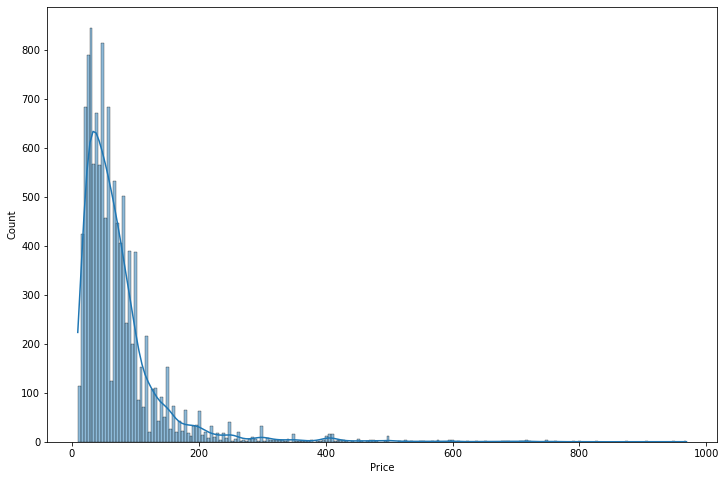

In [9]:
#Pinto el histograma y la curva de densidad:
plt.rcParams['figure.figsize'] = (12, 8)
sns.histplot(df['Price'], kde=True)


**Voy a sumar dentro de "Price" los valores de "Cleaning Fee" y del propio "Price", para tener un valor del precio total del alquiler**

**Previamente, los valores NaN de "Cleaning Fee" los pongo a cero.**

In [10]:
#Imputo el valor 0 a los NA de Cleaning Fee:
df["Cleaning Fee"].fillna(0, inplace=True)

#Sumo a Price el valor de Cleaning Fee y elimino Cleaning Fee:
df["Price"] = df["Price"] + df["Cleaning Fee"]
df = df.drop(["Cleaning Fee"], axis=1)

**Como 'Price' tiene mucha cola, sustituyo los valores por su logaritmo decimal.**

In [11]:
#Paso los valores a logaritmo decimal:
df['Price'] = np.log10(df['Price'])


<AxesSubplot:xlabel='Price', ylabel='Count'>

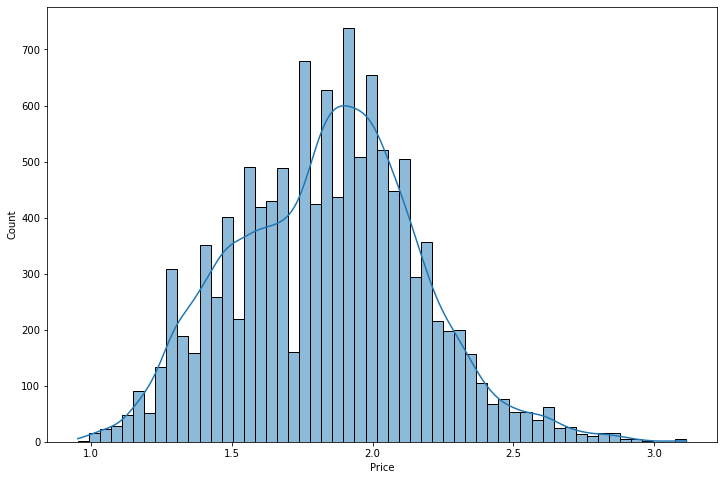

In [12]:
#Pinto el histograma y la curva de densidad para el logaritmo de Price:
plt.rcParams['figure.figsize'] = (12, 8)
sns.histplot(df['Price'], kde=True)

**Voy a mirar las variables para identificar aquellas con muchos Na:**

In [13]:
#Porcentaje de celdas nulas por columna:
null_percent = df.isnull().sum()*100/len(df)
null_percent.sort_values(ascending=False)

Has Availability        99.923787
Host Acceptance Rate    99.745956
Jurisdiction Names      98.535016
License                 97.654331
Square Feet             95.986112
                          ...    
Bed Type                 0.000000
Guests Included          0.000000
Extra People             0.000000
Minimum Nights           0.000000
Country Code             0.000000
Length: 88, dtype: float64

**Varibles con más del 50% de Na no tienen sentido, y no parece además que sean variables que puedan ser significativas en el modelo. Por tanto decido eliminar: 'Has Availability', 'Jurisdiction Names', 'Host Acceptance Rate', 'License', 'Square Feet', 'Monthly Price', 'Weekly Price', 'Notes', 'Security Deposit'.**

In [14]:
#Veo la dimension del df:
print(f'Dimensiones del dataset: {df.shape}')

#Borro 'Has Availability', 'Host Acceptance Rate', 'Jurisdiction Names', 'License', 'Square Feet', 'Monthly Price', 'Weekly Price', 'Notes', 'Security Deposit':
df.drop(columns=['Has Availability', 'Host Acceptance Rate', 'Jurisdiction Names', 'License', 'Square Feet', 'Monthly Price', 'Weekly Price', 'Notes', 'Security Deposit'], inplace=True)

#Veo la dimension del df:
print(f'Dimensiones del dataset: {df.shape}')

Dimensiones del dataset: (11809, 88)
Dimensiones del dataset: (11809, 79)


**Ahora, voy a ver qué valores unicos hay en 'City' porque el ejercicio pide ceñirse a Madrid Capital.**

In [15]:
#Muestro los valores unicos de la columna "City":
ciudades_unicas = df["City"].unique()
print(ciudades_unicas)

['Madrid' 'Illetes' 'Etterbeek' 'Palma' 'Betlem' 'Paris' '马德里' 'Rome'
 'Bondi' 'Seattle' 'Los Angeles' 'Sutton' 'Barcelona' 'Amsterdam' 'Dublin'
 'Berlin' 'Santa Margalida' 'Petra' 'Pasadena' 'London' 'Can Picafort'
 'Santa Maria del Camí' 'Llucmajor' 'Brooklyn' 'Darlinghurst'
 'Sant Llorenç des Cardassar' 'Washington' 'Edinburgh' 'Chicago'
 'Chelsea, London' 'Sencelles' 'Valldemossa' 'New York' 'Manacor' 'Roma'
 'Vancouver' 'Son Servera' 'Madrid, Comunidad de Madrid, ES' 'Antwerpen'
 'Palma de Mallorca' 'Sóller' 'Wien' 'Campanet' 'Denver' 'Venice' 'Enmore'
 'Frederiksberg' 'las matas  madrid' 'Vienna' 'Can Pastilla' 'Selva'
 'Illes Balears' 'Potts Point' 'Melbourne' 'København' 'Pollensa'
 'Toronto' 'Delicias-Madrid' 'Llubí' 'Santanyí' 'Binissalem' 'Algaida'
 'Pozuelo de Alarcón' 'Alcúdia' 'San Francisco' 'Cala Ratjada' 'Deià'
 'Madrid, Comunidad de Madrid, ESPANA' 'Surry Hills' 'Bruxelles'
 'Sant Joan' 'Dorroughby' 'Templeogue' 'La Puebla' 'Ixelles' 'Sa Pobla'
 'Felanitx' 'Ballsbridg

**Limpio las entradas con ciudades que no son Madrid y las entradas que son barrios de Madrid pero que desconozco si pueden ser también barrios de otras ciudades:**

In [16]:
#Creo una máscara con lo que quiero que permanezca:
mascara = df["City"].isin(["Madrid", "Madrid, Comunidad de Madrid, ES", "Delicias-Madrid", "Madrid, Comunidad de Madrid, ESPANA", "madrid", "Madri", "MADRID", "Madid", "Chueca, Madrid", "Aravaca (Madrid)"])

#Aplico la máscara y varío el df original:
df = df.loc[mascara].copy()

#Cambio todos los valores a "Madrid":
df.loc[:, "City"] = "Madrid"

#Ahora ya borro "City":
df.drop(columns=['City'], inplace=True)

#Veo la dimension del df resultante
print(f'La dimensiones del dataset de training era: {train.shape} y la dimension del df en este momento es: {df.shape}')

La dimensiones del dataset de training era: (11824, 89) y la dimension del df en este momento es: (10587, 78)


**Yo viajo bastante por trabajo y me fijo en lo que Airbnb llama 'Amenities'. Hasta el punto que como cliente estoy dispuesto a pagar un poco más por alojamientos que tengan ciertas facilidades. Entonces ¿Funcionará igual la mentalidad del arrendador? ¿Pedirá un precio distinto en funcion de las 'Amenities' que ofrece?**

**¿Pasará igual con la variable "Features"?**

**Voy a tener en cuenta ambas en mi df, pero no con los valores que directamente recogen. Lo que voy a hacer es "contar" el número de cosas que ofrecen y crear una nueva variable numerica que contenga el número de "Amenities". Para "contar el numero de cosas" lo que hago es contar el numero de comas, (de separadores de cosas).**

In [17]:
#Miro qué valores unicos hay en 'Amenities':
unique_values = df['Amenities'].unique()
print(unique_values)


['TV,Internet,Wireless Internet,Air conditioning,Kitchen,Doorman,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,Essentials,Hangers'
 'TV,Internet,Wireless Internet,Air conditioning,Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Smoke detector,Carbon monoxide detector,Essentials,Shampoo,24-hour check-in,Hangers,Hair dryer,Iron,Laptop friendly workspace'
 'Internet,Wireless Internet,Wheelchair accessible,Pool,Kitchen,Free parking on premises,Doorman,Breakfast,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Suitable for events,Washer,Smoke detector,First aid kit,Safety card,Fire extinguisher,Essentials,Shampoo,Lock on bedroom door,Hangers,Hair dryer,Iron,Laptop friendly workspace'
 ...
 'TV,Internet,Wireless Internet,Kitchen,Breakfast,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,First aid kit,Safety card,Essentials,Shampoo,Hangers,Iron,Laptop friendly workspace'
 'TV,Cable TV,W

In [18]:
#Miro el numero de Na en "Amenities" para confirmar que es un numero muy pequeño de casos:
Amenities_NaN = df['Amenities'].isna().sum()

print(f'En un total de {df.shape[0]} registros, los NaN en la variable "Amenities" son: {Amenities_NaN}')

En un total de 10587 registros, los NaN en la variable "Amenities" son: 89


In [19]:
#No llega la 1%. Decido borrar los Na:
df.dropna(subset=['Amenities'], inplace=True)
#df['Amenities'].replace({np.nan: 0}, inplace=True)

In [20]:
#Creo nueva varible N_Amenities con el nunero de comas (de "cosas") que ofrecen como 'Amenitie': 
df['N_Amenities'] = df['Amenities'].str.count(',') + 1
#He añadido "+1" para incluir el último elemento, que no lleva una coma.
unique_values = df['N_Amenities'].unique()
print(unique_values)

[13 18 25  5 15 20 12 23 11 14  9 19 17  8 10 27 16 21  6  7 24 26 22  1
  4 28 29  2  3 31 30 34 32]


In [21]:
#Y borro 'Amenities' que ya no lo necesito:
df.drop('Amenities', axis=1, inplace=True)


**Repito el concepto con "Features" (características adicionales de la vivienda, por ejemplo, ascensor, estacionamiento, etc.).**

In [22]:
#Miro los valores unicos hay en 'Features':
unique_values = df['Features'].unique()
print(unique_values)


['Host Has Profile Pic,Is Location Exact,Requires License'
 'Host Has Profile Pic,Host Identity Verified,Requires License,Instant Bookable'
 'Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Instant Bookable'
 'Host Has Profile Pic,Requires License'
 'Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License'
 'Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License'
 'Host Is Superhost,Host Has Profile Pic,Requires License'
 'Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Require Guest Profile Picture,Require Guest Phone Verification'
 'Host Has Profile Pic,Is Location Exact,Requires License,Instant Bookable'
 'Host Is Superhost,Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Require Guest Profile Picture,Require Guest Phone Verification'
 'Host Has Profile Pic,Is Location Exact,Requires License,Require Guest Phone Verification'
 'H

**Estos valores no parece que todos tengasn relacion con caracteristicas de las viviendas que puedan tener impacto en el precio. Por tanto decido elimnar del df esta variables.**

In [23]:
#Y borro 'Features' que ya no lo necesito:
df.drop('Features', axis=1, inplace=True)


In [24]:
#Miro la dimensionalidad
print(f'Las dimensiones del dataset actualmente son: {df.shape}')

Las dimensiones del dataset actualmente son: (10498, 77)


**Voy a mirar los datos numéricos a ver qué veo:**

In [25]:
#Resumen de las variables numéricas:
df.describe().T

count          mean           std  \
Price                           10498.0  1.810041e+00  3.128946e-01   
ID                              10498.0  1.038938e+07  5.508694e+06   
Scrape ID                       10498.0  2.017041e+13  4.320518e+00   
Host ID                         10498.0  3.713723e+07  3.420554e+07   
Host Response Rate               9223.0  9.490914e+01  1.502800e+01   
Host Listings Count             10495.0  1.004097e+01  2.805199e+01   
Host Total Listings Count       10495.0  1.004097e+01  2.805199e+01   
Latitude                        10498.0  4.042041e+01  1.976085e-02   
Longitude                       10498.0 -3.697117e+00  2.326720e-02   
Accommodates                    10498.0  3.194227e+00  1.989995e+00   
Bathrooms                       10477.0  1.256657e+00  6.056994e-01   
Bedrooms                        10480.0  1.295802e+00  8.340162e-01   
Beds                            10476.0  1.994082e+00  1.527774e+00   
Guests Included                 10498.0  1.573633e+00  1.075132e+00   
Extra People                    10498.0  7.442656e+00  1.036760e+01   
Minimum Nights                  10498.0  3.057440e+00  1.372337e+01   
Maximum Nights                  10498.0  9.765963e+02  9.961266e+03   
Availability 30                 10498.0  8.634597e+00  8.985059e+00   
Availability 60                 10498.0  2.271595e+01  1.938602e+01   
Availability 90                 10498.0  3.981168e+01  2.918942e+01   
Availability 365                10498.0  2.051920e+02  1.268451e+02   
Number of Reviews               10498.0  2.332073e+01  3.844933e+01   
Review Scores Rating             8267.0  9.160651e+01  9.097377e+00   
Review Scores Accuracy           8252.0  9.407174e+00  9.371147e-01   
Review Scores Cleanliness        8256.0  9.324734e+00  1.003832e+00   
Review Scores Checkin            8246.0  9.627577e+00  7.888926e-01   
Review Scores Communication      8255.0  9.648940e+00  7.522383e-01   
Review Scores Location           8243.0  9.548101e+00  7.570487e-01   
Review Scores Value              8244.0  9.210577e+00  9.632604e-01   
Calculated host listings count  10498.0  7.802724e+00  1.996544e+01   
Reviews per Month                8371.0  1.932560e+00  1.890744e+00   
N_Amenities                     10498.0  1.442437e+01  4.583401e+00   

                                         min           25%           50%  \
Price                           1.000000e+00  1.579784e+00  1.838849e+00   
ID                              1.986400e+04  5.803920e+06  1.150341e+07   
Scrape ID                       2.017041e+13  2.017041e+13  2.017041e+13   
Host ID                         1.745300e+04  7.764082e+06  2.715626e+07   
Host Response Rate              0.000000e+00  1.000000e+02  1.000000e+02   
Host Listings Count             0.000000e+00  1.000000e+00  2.000000e+00   
Host Total Listings Count       0.000000e+00  1.000000e+00  2.000000e+00   
Latitude                        4.033291e+01  4.041010e+01  4.041844e+01   
Longitude                      -3.835498e+00 -3.707758e+00 -3.701552e+00   
Accommodates                    1.000000e+00  2.000000e+00  2.000000e+00   
Bathrooms                       0.000000e+00  1.000000e+00  1.000000e+00   
Bedrooms                        0.000000e+00  1.000000e+00  1.000000e+00   
Beds                            1.000000e+00  1.000000e+00  2.000000e+00   
Guests Included                 1.000000e+00  1.000000e+00  1.000000e+00   
Extra People                    0.000000e+00  0.000000e+00  5.000000e+00   
Minimum Nights                  1.000000e+00  1.000000e+00  2.000000e+00   
Maximum Nights                  1.000000e+00  3.650000e+02  1.125000e+03   
Availability 30                 0.000000e+00  0.000000e+00  6.000000e+00   
Availability 60                 0.000000e+00  5.000000e+00  2.000000e+01   
Availability 90                 0.000000e+00  1.225000e+01  3.800000e+01   
Availability 365                0.000000e+00  8.300000e+01  2.470000e+02   
Number of Reviews 

**Puede haber posibles outliers en "Beds", "Minimum Nights" y "Maximum Nights". <font color="red">Lo tengo en cuenta para mirarlo con detalle más adelante.</font>**


**Miro el numero de valores unicos de cada columna.**

In [26]:
#Muestro el numero de valores unicos de cada columna numerica:
df.select_dtypes(include='number').nunique()

Price                               330
ID                                10498
Scrape ID                             1
Host ID                            6715
Host Response Rate                   66
Host Listings Count                  48
Host Total Listings Count            48
Latitude                          10498
Longitude                         10498
Accommodates                         16
Bathrooms                            15
Bedrooms                             10
Beds                                 16
Guests Included                      14
Extra People                         49
Minimum Nights                       39
Maximum Nights                      152
Availability 30                      31
Availability 60                      61
Availability 90                      91
Availability 365                    366
Number of Reviews                   244
Review Scores Rating                 51
Review Scores Accuracy                9
Review Scores Cleanliness             9


**Como Scrape ID solo tiene un valor único la quito del df.**

In [27]:
#Borro 'Scrape ID' que ya no lo necesito:
df.drop('Scrape ID', axis=1, inplace=True)

In [28]:
#Miro la dimensionalidad
print(f'Las dimensiones del dataset actualmente son: {df.shape}')

Las dimensiones del dataset actualmente son: (10498, 76)


**Voy a mirar el tipo de dato de cada columna:**

In [29]:
#Miro el tipo de dato de cada columna:
pd.options.display.max_rows = len(df) #Jupyter limita el nº de filas que muestra: aumento el máximo de filas mostradas
print(df.dtypes.sort_values())

N_Amenities                         int64
Accommodates                        int64
Guests Included                     int64
Extra People                        int64
Host ID                             int64
Minimum Nights                      int64
Maximum Nights                      int64
Availability 30                     int64
Availability 90                     int64
Availability 365                    int64
Number of Reviews                   int64
Availability 60                     int64
ID                                  int64
Review Scores Accuracy            float64
Latitude                          float64
Longitude                         float64
Bathrooms                         float64
Bedrooms                          float64
Beds                              float64
Review Scores Rating              float64
Reviews per Month                 float64
Review Scores Value               float64
Review Scores Location            float64
Review Scores Communication       

**Hay muchos datos tipo object. Voy a mirarlos más de cerca:**

In [30]:
# Selecciono las columnas tipo "object" y las muestro:
df_object = df.select_dtypes(include=['object'])

print(df_object.head(1).T)

                                                                              0
Listing Url                                https://www.airbnb.com/rooms/5994463
Last Scraped                                                         2017-04-08
Name                                           PISO ATOCHA- FLAT NEAR ATOCHA  .
Summary                       Piso recién reformado cómoda habitación con ba...
Space                         Un piso muy cómodo en Jerónimos, una de las zo...
Description                   Piso recién reformado cómoda habitación con ba...
Experiences Offered                                                        none
Neighborhood Overview         El barrio de Jeronimos es un enclave tranquilo...
Transit                       Excelente ubicación a tan solo 5 minutos andan...
Access                        La conexión a internet por fibra óptica 100 MB...
Interaction                   Recibimos personalmente a nuestros huéspedes y...
House Rules                   El apartam

**Varias columnas parecen prescindibles.**

**Pero antes de nada miro en internet la descripción de cada uno de los valores o columnas del df:**

- ID: es un identificador único asignado a cada anuncio en Airbnb.
- Listing URL: es la dirección web del anuncio en Airbnb.
- Scrape ID: es un identificador único asignado a cada vez que se realiza un "scrape" de los datos del anuncio.
- Last Scraped: es la fecha y hora en la que se realizó la última "scrape" del anuncio.
- Name: es el nombre o título del anuncio.
- Summary: es un resumen o descripción breve del anuncio.
- Space: es una descripción de los espacios disponibles para el huésped en la vivienda.
- Description: es una descripción detallada del anuncio.
- Experiences Offered: indica si el anfitrión ofrece alguna experiencia o actividad adicional al huésped.
- Neighborhood Overview: es una descripción del barrio o zona donde se encuentra la vivienda.
- Notes: son notas adicionales que el anfitrión quiere destacar sobre el anuncio.
- Transit: es una descripción de los medios de transporte disponibles cerca de la vivienda.
- Access: es una descripción de qué espacios de la vivienda estarán disponibles para el huésped.
- Interaction: es una descripción de la interacción que el anfitrión espera tener con el huésped.
- House Rules: son las reglas o normas que el anfitrión espera que el huésped siga durante su estancia.
- Thumbnail URL: es la dirección web de la imagen miniatura (thumbnail) del anuncio.
- Medium URL: es la dirección web de la imagen de tamaño mediano del anuncio.
- Picture URL: es la dirección web de la imagen principal del anuncio.
- XL Picture URL: es la dirección web de la imagen en tamaño extra grande del anuncio.
- Host ID: es el identificador único del anfitrión en Airbnb.
- Host URL: es la dirección web del perfil del anfitrión en Airbnb.
- Host Name: es el nombre del anfitrión.
- Host Since: es la fecha en la que el anfitrión se registró en Airbnb.
- Host Location: es la ubicación del anfitrión en términos de ciudad o país.
- Host About: es una descripción del anfitrión proporcionada por el mismo.
- Host Response Time: es el tiempo que el anfitrión suele tardar en responder a las solicitudes de reserva o mensajes.
- Host Response Rate: es la tasa de respuesta del anfitrión a las solicitudes de reserva o mensajes.
- Host Acceptance Rate: es la tasa de aceptación del anfitrión a las solicitudes de reserva.
- Host Thumbnail Url: es la dirección web de la imagen miniatura (thumbnail) del perfil del anfitrión.
- Host Picture Url: es la dirección web de la imagen principal del perfil del anfitrión.
- Host Neighbourhood: es el barrio o zona donde el anfitrión vive.
- Host Listings Count: es el número de anuncios que el anfitrión tiene en Airbnb.
- Host Total Listings Count: es el número total de anuncios que el anfitrión ha tenido en Airbnb desde que se registró.
- Host Verifications: son los métodos de verificación que el anfitrión ha completado para demostrar su identidad.
- Street: es la calle o avenida donde se encuentra la vivienda.
- Neighbourhood: es el barrio o zona donde se encuentra la vivienda.
- Neighbourhood Cleansed: es el barrio o zona donde se encuentra la vivienda, pero con la información de formato unificado.
- Neighbourhood Group Cleansed: es el grupo de barrios al que pertenece el barrio donde se encuentra la vivienda, con la información de formato unificado.
- City: es la ciudad donde se encuentra la vivienda.
- State: es el estado o región donde se encuentra la vivienda.
- Zipcode: es el código postal de la zona donde se encuentra la vivienda.
- Market: es el mercado en el que se encuentra la vivienda (por ejemplo, Nueva York).
- Smart Location: es una ubicación "inteligente" asignada a la vivienda que refleja la verdadera ubicación en términos de barrio o zona, más allá de la dirección exacta.
- Country Code: es el código del país donde se encuentra la vivienda.
- Country: es el nombre del país donde se encuentra la vivienda.
- Latitude: es la coordenada de latitud de la ubicación de la vivienda.
- Longitude: es la coordenada de longitud de la ubicación de la vivienda.
- Property Type: es el tipo de propiedad (por ejemplo, casa, departamento, etc.).
- Room Type: es el tipo de habitación (por ejemplo, habitación privada, habitación compartida, etc.).
- Accommodates: es el número de personas que la vivienda puede alojar.
- Bathrooms: es el número de baños disponibles en la vivienda.
- Bedrooms: es el número de habitaciones con cama disponibles en la vivienda.
- Beds: es el número total de camas disponibles en la vivienda.
- Bed Type: es el tipo de cama (por ejemplo, cama doble, cama individual, etc.).
- Amenities: son las comodidades o servicios disponibles en la vivienda (por ejemplo, cocina, wifi, etc.).
- Square Feet: es el tamaño de la vivienda en pies cuadrados.
- Price: es el precio por noche para alquilar la vivienda.
- Weekly Price: es el precio por semana para alquilar la vivienda.
- Monthly Price: es el precio por mes para alquilar la vivienda.
- Security Deposit: es el depósito de seguridad que se pide al huésped al hacer la reserva.
- Cleaning Fee: es la tarifa por limpieza que se cobra al huésped.
- Guests Included: es el número de huéspedes incluidos en el precio.
- Extra People: es la tarifa adicional por persona adicional que se cobra al huésped.
- Minimum Nights: es el número mínimo de noches que se puede reservar la vivienda.
- Maximum Nights: es el número máximo de noches que se puede reservar la vivienda.
- Calendar Updated: es la fecha en la que se actualizó el calendario de disponibilidad de la vivienda.
- Has Availability: indica si la vivienda tiene disponibilidad para reservas.
- Availability 30: es la disponibilidad de la vivienda para los próximos 30 días.
- Availability 60: es la disponibilidad de la vivienda para los próximos 60 días.
- Availability 90: es la disponibilidad de la vivienda para los próximos 90 días.
- Availability 365: es la disponibilidad de la vivienda para los próximos 365 días.
- Calendar last Scraped: es la fecha en la que se realizó la última "scrape" del calendario de disponibilidad de la vivienda.
- Number of Reviews: es el número total de reseñas que ha recibido la vivienda.
- First Review: es la fecha de la primera reseña que recibió la vivienda.
- Last Review: es la fecha de la última reseña que recibió la vivienda.
- Review Scores Rating: es la puntuación promedio de las reseñas recibidas por la vivienda.
- Review Scores Accuracy: es la puntuación promedio de las reseñas en términos de precisión de la descripción del anuncio.
- Review Scores Cleanliness: es la puntuación promedio de las reseñas en términos de limpieza de la vivienda.
- Review Scores Checkin: es la puntuación promedio de las reseñas en términos de facilidad para hacer el check-in.
- Review Scores Communication: es la puntuación promedio de las reseñas en términos de comunicación con el anfitrión.
- Review Scores Location: es la puntuación promedio de las reseñas en términos de ubicación de la vivienda.
- Review Scores Value: es la puntuación promedio de las reseñas en términos de relación calidad-precio.
- License: es el número de licencia de la vivienda, si es aplicable.
- Jurisdiction Names: es el nombre de la jurisdicción o autoridad local que emitió la licencia de la vivienda, si es aplicable.
- Cancellation Policy: es la política de cancelación de la vivienda.
- Calculated host listings count: es el número de anuncios del anfitrión que fueron incluidos en el cálculo de la tasa de respuesta y aceptación del anfitrión.
- Reviews per Month: es el número promedio de reseñas que recibe la vivienda por mes.
- Geolocation: es la ubicación geográfica de la vivienda.
- Features: son las características adicionales de la vivienda (por ejemplo, ascensor, estacionamiento, etc.).


**Las siguientes columnas las decido borrar porque no creo que aporten información al futuro modelo:**

- Listing URL: es la dirección web del anuncio en Airbnb.
- Last Scraped: es la fecha y hora en la que se realizó la última "scrape" del anuncio.
- Name: es el nombre o título del anuncio.
- Summary: es un resumen o descripción breve del anuncio.
- Space: es una descripción de los espacios disponibles para el huésped en la vivienda.
- Description: es una descripción detallada del anuncio.
- Experiences Offered: indica si el anfitrión ofrece alguna experiencia o actividad adicional al huésped.
- Neighborhood Overview: es una descripción del barrio o zona donde se encuentra la vivienda.
- Transit: es una descripción de los medios de transporte disponibles cerca de la vivienda.
- Access: es una descripción de qué espacios de la vivienda estarán disponibles para el huésped.
- Interaction: es una descripción de la interacción que el anfitrión espera tener con el huésped.
- House Rules: son las reglas o normas que el anfitrión espera que el huésped siga durante su estancia.
- Host ID: es el identificador único del anfitrión en Airbnb.
- Host URL: es la dirección web del perfil del anfitrión en Airbnb.
- Host Name: es el nombre del anfitrión.
- Host Since: es la fecha en la que el anfitrión se registró en Airbnb.
- Host Location: es la ubicación del anfitrión en términos de ciudad o país.
- Host About: es una descripción del anfitrión proporcionada por el mismo.
- Host Thumbnail Url: es la dirección web de la imagen miniatura (thumbnail) del perfil del anfitrión.
- Host Picture Url: es la dirección web de la imagen principal del perfil del anfitrión.
- Host Neighbourhood: es el barrio o zona donde el anfitrión vive.
- Host Total Listings Count: es el número total de anuncios que el anfitrión ha tenido en Airbnb desde que se registró.
- Host Verifications: son los métodos de verificación que el anfitrión ha completado para demostrar su identidad.
- Country Code: es el código del país donde se encuentra la vivienda.
- Country: es el nombre del país donde se encuentra la vivienda.
- Maximum Nights: es el número máximo de noches que se puede reservar la vivienda.
- Calendar Updated: es la fecha en la que se actualizó el calendario de disponibilidad de la vivienda.
- Availability 60: es la disponibilidad de la vivienda para los próximos 60 días.
- Availability 90: es la disponibilidad de la vivienda para los próximos 90 días.
- Availability 365: es la disponibilidad de la vivienda para los próximos 365 días.
- Calendar last Scraped: es la fecha en la que se realizó la última "scrape" del calendario de disponibilidad de la vivienda.
- Cancellation Policy: es la política de cancelación de la vivienda.
- Calculated host listings count: es el número de anuncios del anfitrión que fueron incluidos en el cálculo de la tasa de respuesta y aceptación del anfitrión.
- Geolocation: es la ubicación geográfica de la vivienda.

In [31]:
#Procedo a borrar las columnas citadas:
df.drop(columns=['Listing Url', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 'Experiences Offered', 
                 'Neighborhood Overview', 'Transit', 'Access', 'Interaction', 'House Rules', 'Host ID', 'Host URL', 'Host Name', 
                 'Host Since', 'Host Location', 'Host About', 'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 
                 'Host Total Listings Count', 'Host Verifications', 'Country Code', 'Country', 
                 'Maximum Nights', 'Calendar Updated', 'Availability 60', 'Availability 90', 'Availability 365', 
                 'Calendar last Scraped', 'Cancellation Policy', 'Calculated host listings count', 'Geolocation'], inplace=True)

#Mera comprobación de las columnas que permanecen:
pd.options.display.max_rows = len(df)
print(df.dtypes.sort_values())

N_Amenities                       int64
Guests Included                   int64
Extra People                      int64
Minimum Nights                    int64
Availability 30                   int64
Accommodates                      int64
Number of Reviews                 int64
ID                                int64
Review Scores Accuracy          float64
Review Scores Rating            float64
Review Scores Checkin           float64
Review Scores Communication     float64
Review Scores Location          float64
Review Scores Value             float64
Beds                            float64
Bedrooms                        float64
Bathrooms                       float64
Review Scores Cleanliness       float64
Reviews per Month               float64
Price                           float64
Longitude                       float64
Latitude                        float64
Host Response Rate              float64
Host Listings Count             float64
Thumbnail Url                    object


**Las columnas 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url' contienen, como es obvio, datos de url de los cuatro posibles tamaños de fotos de los anuncios. Este dato no me iteresa, pero si me puede interesar ver si el que tengan o no dichas fotos se relaciona con el precio de alquiler. Y creo una nueva variable 'Pictures' que me da la suma de las anteriores.**

**'Pictures' valdrá 4 si todas las 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url' contienen url**

**'Pictures' valdrá 3 si tres de las 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url' contienen url**

**Etc...**

**Re-escribo dichas columnas con un 1 si tienen Url (si empiezan por "http") y con un "0" en el resto de casos.**

In [32]:
#Paso a string las columnas cuyo valor voy a cambiar:
df[["Thumbnail Url", "Medium Url", "Picture Url", "XL Picture Url"]] = df[["Thumbnail Url", "Medium Url", "Picture Url", "XL Picture Url"]].applymap(str)

for col in ['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url']:
    df[col] = df[col].apply(lambda x: 1 if x.startswith('http') else 0)
    
#Miro los valores que cotienen esas columnas por si hay en ellas valores NA
value_counts_ThumbnailUrl = df['Thumbnail Url'].value_counts()
print(value_counts_ThumbnailUrl)

value_counts_MediumUrl = df['Medium Url'].value_counts()
print(value_counts_MediumUrl)

value_counts_PictureUrl = df['Picture Url'].value_counts()
print(value_counts_PictureUrl)

value_counts_XLPictureUrl = df['XL Picture Url'].value_counts()
print(value_counts_XLPictureUrl)


#Paso las columnas cambiadas a tipo entero sin signo de 8 bits:
cols = ['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url']
df[cols] = df[cols].apply(lambda x: x.astype(np.uint8))

#Mera comprobación
pd.options.display.max_rows = len(df)
#print(df.dtypes.sort_values())

#df.head()

1    8514
0    1984
Name: Thumbnail Url, dtype: int64
1    8514
0    1984
Name: Medium Url, dtype: int64
1    10480
0       18
Name: Picture Url, dtype: int64
1    8514
0    1984
Name: XL Picture Url, dtype: int64


**Y creo la nueva variable “Pictures” que me da la suma de las anteriores, y borro 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url'.**

In [33]:
#Nueva variable “Pictures” que me da la suma de las anteriores:
df['Pictures'] = df[['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url']].sum(axis=1)

#Borro 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url':
df.drop(columns=['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url'], inplace=True)

#Mera comprobación
print(df.dtypes.sort_values())
print('\n\n')
df.head().T

Pictures                          int64
Guests Included                   int64
Extra People                      int64
Minimum Nights                    int64
Availability 30                   int64
Number of Reviews                 int64
N_Amenities                       int64
Accommodates                      int64
ID                                int64
Review Scores Checkin           float64
Review Scores Rating            float64
Review Scores Communication     float64
Review Scores Location          float64
Review Scores Value             float64
Reviews per Month               float64
Beds                            float64
Review Scores Cleanliness       float64
Review Scores Accuracy          float64
Price                           float64
Bedrooms                        float64
Host Response Rate              float64
Longitude                       float64
Latitude                        float64
Host Listings Count             float64
Bathrooms                       float64


0  \
Price                                                                  1.929419   
ID                                                                      5994463   
Host Response Time                                           within a few hours   
Host Response Rate                                                        100.0   
Host Listings Count                                                         2.0   
Street                        Jerónimos, Madrid, Comunidad de Madrid 28014, ...   
Neighbourhood                                                         Jerónimos   
Neighbourhood Cleansed                                                Jerónimos   
Neighbourhood Group Cleansed                                             Retiro   
State                                                       Comunidad de Madrid   
Zipcode                                                                   28014   
Market                                                                   Madrid   
Smart Location                                                    Madrid, Spain   
Latitude                                                              40.407732   
Longitude                                                             -3.684819   
Property Type                                                         Apartment   
Room Type                                                       Entire home/apt   
Accommodates                                                                  4   
Bathrooms                                                                   1.0   
Bedrooms                                                                    1.0   
Beds                                                                        2.0   
Bed Type                                                               Real Bed   
Guests Included                                                               1   
Extra People                                                                  0   
Minimum Nights                                                                2   
Availability 30                                                               9   
Number of Reviews                                                            12   
First Review                                                         2015-04-26   
Last Review                                                          2017-02-28   
Review Scores Rating                                                       95.0   
Review Scores Accuracy                                                      9.0   
Review Scores Cleanliness                                                  10.0   
Review Scores Checkin                                                      10.0   
Review Scores Communication                                                10.0   
Review Scores Location                                                     10.0   
Review Scores Value                                                         9.0   
Reviews per Month                                                           0.5   
N_Amenities                                                                  13   
Pictures                                                                      4   

                                                                     1  \
Price                                                         1.812913   
ID                                                            14136180   
Host Response Time                                      within an hour   
Host Response Rate                                               100.0   
Host Listings Count                                                1.0   
Street                        Madrid, Comunidad de Madrid 28012, Spain   
Neighbourhood                                                      NaN   
Neighbourhood Cleansed                                             Sol   
Neighbourhood Group Cleansed                                    Centro   
State            

In [34]:
#Muestro el numero de valores unicos de cada columna de tipo objeto:
Tipo_objeto = df.select_dtypes(include='object').nunique()
Tipo_objeto = Tipo_objeto.sort_values()
print(Tipo_objeto)


Room Type                          3
Host Response Time                 4
Market                             4
Bed Type                           5
Smart Location                    12
State                             16
Property Type                     20
Neighbourhood Group Cleansed      21
Neighbourhood                     65
Zipcode                           67
Neighbourhood Cleansed           125
Street                           636
Last Review                      657
First Review                    1508
dtype: int64


**Veo que la variable "Room Type" es categórica por lo que conviene codificarla. Para ello voy a usar Mean Encoding.**

In [35]:
#codifico "Room Type"
mean_encoding = df.groupby('Room Type')['Price'].mean().to_dict()
Room_Type_dict = {k: v for k, v in zip(mean_encoding.keys(), mean_encoding.values())}
df['Room Type'] = df['Room Type'].map(mean_encoding)

# El diccionario "Room_Type_dict" contiene los valores originales de "Room Type" como claves 
# y los valores numéricos de reemplazo como valores.
print(Room_Type_dict)

{'Entire home/apt': 1.995539913662348, 'Private room': 1.5359483127726252, 'Shared room': 1.3670968167473136}


**Idem para la variable "Host Response Time".**

In [36]:
#codifico "Host Response Time"
mean_encoding = df.groupby('Host Response Time')['Price'].mean().to_dict()
Host_Response_Time_dict = {k: v for k, v in zip(mean_encoding.keys(), mean_encoding.values())}
df['Host Response Time'] = df['Host Response Time'].map(mean_encoding)

# El diccionario "Host_Response_Time_dict" contiene los valores originales de "Host Response Time" como claves 
# y los valores numéricos de reemplazo como valores.
print(Host_Response_Time_dict)

{'a few days or more': 1.765850535702032, 'within a day': 1.750963865223261, 'within a few hours': 1.8196725192722925, 'within an hour': 1.8426114223875767}


**Idem para la variable "Bed Type".**

In [37]:
mean_encoding = df.groupby('Bed Type')['Price'].mean().to_dict()
Bed_Type_dict = {k: v for k, v in zip(mean_encoding.keys(), mean_encoding.values())}
df['Bed Type'] = df['Bed Type'].map(mean_encoding)

# El diccionario "Bed_Type_dict" contiene los valores originales de "Bed Typee" como claves 
# y los valores numéricos de reemplazo como valores.
print(Bed_Type_dict)

{'Airbed': 1.7720076779614389, 'Couch': 1.7089377574449065, 'Futon': 1.6945132545220511, 'Pull-out Sofa': 1.8069710289145924, 'Real Bed': 1.8105805147829315}


**Idem para la variable "Property Type".**

In [38]:
mean_encoding = df.groupby('Property Type')['Price'].mean().to_dict()
Property_Type_dict = {k: v for k, v in zip(mean_encoding.keys(), mean_encoding.values())}
df['Property Type'] = df['Property Type'].map(mean_encoding)

# El diccionario "Property_Type_dict" contiene los valores originales de "Property Type" como claves 
# y los valores numéricos de reemplazo como valores.
print(Property_Type_dict)

{'Apartment': 1.8282133663319802, 'Bed & Breakfast': 1.5769714008666866, 'Boutique hotel': 1.8116721541970062, 'Bungalow': 1.2304489213782739, 'Camper/RV': 1.4771212547196624, 'Casa particular': 1.4571457724680335, 'Chalet': 1.7939472478799394, 'Condominium': 1.7682818400153864, 'Dorm': 1.5482910804802743, 'Earth House': 1.3464234596386149, 'Guest suite': 1.3537850880489684, 'Guesthouse': 1.5861485888956464, 'Hostel': 1.6152849611925721, 'House': 1.6990683144747143, 'Loft': 1.9074188527571718, 'Other': 1.7848893777121912, 'Serviced apartment': 1.7643490357155747, 'Tent': 1.5314789170422551, 'Townhouse': 1.7217097470783873, 'Villa': 2.3320184136282887}


**Me voy a fijar en las columnas siguientes para ver qué contienen exactamente:**
    
- Street: es la calle o avenida donde se encuentra la vivienda.
- Neighbourhood: es el barrio o zona donde se encuentra la vivienda.
- Neighbourhood Cleansed: es el barrio o zona donde se encuentra la vivienda, pero con la información de formato unificado.
- Neighbourhood Group Cleansed: es el grupo de barrios al que pertenece el barrio donde se encuentra la vivienda, con la información de formato unificado.
- State: es el estado o región donde se encuentra la vivienda.
- Zipcode: es el código postal de la zona donde se encuentra la vivienda.
- Market: es el mercado en el que se encuentra la vivienda (por ejemplo, Nueva York).
- Smart Location: es una ubicación "inteligente" asignada a la vivienda que refleja la verdadera ubicación en términos de barrio o zona, más allá de la dirección exacta.

    
    

In [39]:
columnas = df[["Street", "Neighbourhood", "Neighbourhood Cleansed", "Neighbourhood Group Cleansed", "State", "Zipcode", "Market", "Smart Location" ]]

# Mostramos el resultado
print(columnas)

                                                  Street        Neighbourhood  \
0      Jerónimos, Madrid, Comunidad de Madrid 28014, ...            Jerónimos   
1               Madrid, Comunidad de Madrid 28012, Spain                  NaN   
2      Carabanchel, Madrid, Comunidad de Madrid 28025...          Carabanchel   
3               Madrid, Comunidad de Madrid 28012, Spain                  NaN   
4                    Gaztambide, Madrid, 28 28015, Spain           Gaztambide   
5      Embajadores, Madrid, Comunidad de Madrid 28012...          Embajadores   
6               Madrid, Comunidad de Madrid 28005, Spain                  NaN   
7          Sol, Madrid, Comunidad de Madrid 28013, Spain                  Sol   
9         Goya, Madrid, Comunidad de Madrid 28006, Spain                 Goya   
10     Embajadores, Madrid, Comunidad de Madrid 28012...          Embajadores   
11     Fuente del Berro, Madrid, Comunidad de Madrid ...     Fuente del Berro   
12              Madrid, Comu

**Parece que "Street" contiene info que está detallada en otras columnas: la elimino.**

**Por redundantes elimino también "Neighbourhood", "State", "Zipcode" y "Market"**
    

In [40]:
#Elimino dichs columnas:
df.drop(columns=['Street', 'Neighbourhood', 'State', 'Zipcode', 'Market'], inplace=True)

#Mera comprobación:
pd.options.display.max_rows = len(df)
print(df.dtypes.sort_values())

Pictures                          int64
Extra People                      int64
Minimum Nights                    int64
Accommodates                      int64
Availability 30                   int64
Number of Reviews                 int64
Guests Included                   int64
N_Amenities                       int64
ID                                int64
Review Scores Checkin           float64
Review Scores Rating            float64
Review Scores Communication     float64
Review Scores Location          float64
Review Scores Value             float64
Reviews per Month               float64
Review Scores Cleanliness       float64
Review Scores Accuracy          float64
Price                           float64
Bedrooms                        float64
Bathrooms                       float64
Room Type                       float64
Property Type                   float64
Longitude                       float64
Latitude                        float64
Host Listings Count             float64


**Voy a ver qué valores contiene "Smart Location"**

In [41]:
#Muestro los valores unicos de la columna "Smart Location":
SL_unicas = df["Smart Location"].unique()
print(SL_unicas)

['Madrid, Spain' 'Madrid, Comunidad de Madrid, ES, Spain'
 'Delicias-Madrid, Spain' 'Madrid, Comunidad de Madrid, ESPANA, Spain'
 'madrid, Spain' 'Madrid , Spain' 'Madri, Spain' 'MADRID , Spain'
 'Madid, Spain' 'Chueca, Madrid, Spain' 'MADRID, Spain'
 'Aravaca (Madrid), Spain']


**Efectivamente "Smart Location" ya no me aporta nada puesto que me he quedado solo con propiedades de Madrid Capital, por lo que elimino la columna.**

In [42]:
#Elimino las columna:
df.drop(columns=['Smart Location'], inplace=True)

#Mera comprobación de las columnas que permanecen:
pd.options.display.max_rows = len(df)
print(df.dtypes.sort_values())

Guests Included                   int64
Number of Reviews                 int64
Availability 30                   int64
Minimum Nights                    int64
Extra People                      int64
N_Amenities                       int64
Accommodates                      int64
Pictures                          int64
ID                                int64
Reviews per Month               float64
Review Scores Value             float64
Review Scores Location          float64
Review Scores Communication     float64
Review Scores Checkin           float64
Review Scores Cleanliness       float64
Review Scores Accuracy          float64
Review Scores Rating            float64
Latitude                        float64
Host Response Time              float64
Longitude                       float64
Host Listings Count             float64
Bed Type                        float64
Beds                            float64
Bedrooms                        float64
Bathrooms                       float64


**Voy a mirar las variables "Neighbourhood Group Cleansed" y "Neighbourhood Cleansed"**

In [43]:
NGC_unicos = df['Neighbourhood Group Cleansed'].value_counts()

NC_unicos = df['Neighbourhood Cleansed'].value_counts()

print(NGC_unicos, end='\n\n')
print(NC_unicos)

Centro                   5392
Chamberí                  755
Salamanca                 715
Arganzuela                633
Tetuán                    361
Retiro                    351
Moncloa - Aravaca         329
Latina                    293
Carabanchel               284
Chamartín                 278
Ciudad Lineal             243
Puente de Vallecas        169
Hortaleza                 138
Usera                     110
Fuencarral - El Pardo     110
San Blas - Canillejas      90
Barajas                    64
Moratalaz                  61
Villaverde                 59
Villa de Vallecas          37
Vicálvaro                  26
Name: Neighbourhood Group Cleansed, dtype: int64

Embajadores                     1471
Universidad                     1050
Palacio                          876
Sol                              770
Justicia                         627
Cortes                           598
Trafalgar                        253
Argüelles                        210
Palos de Moguer         

**Lo que tenemos es informacion sobre Distritos en la variable "Neighbourhood Group Cleansed", mientras que la variable "Neighbourhood Cleansed" habla de Barrios.**

**Como ambas son categóricas de nuevo recurro a Mean Encoding para regularizarlas.**

In [44]:
mean_encoding = df.groupby('Neighbourhood Group Cleansed')['Price'].mean().to_dict()
Neighbourhood_Group_Cleansed_dict = {k: v for k, v in zip(mean_encoding.keys(), mean_encoding.values())}
df['Neighbourhood Group Cleansed'] = df['Neighbourhood Group Cleansed'].map(mean_encoding)

# El diccionario "Neighbourhood_Group_Cleansed_dict" contiene los valores originales de "Neighbourhood Group Cleansed" como claves 
# y los valores numéricos de reemplazo como valores.
print(Neighbourhood_Group_Cleansed_dict)

print('\n\n')

mean_encoding = df.groupby('Neighbourhood Cleansed')['Price'].mean().to_dict()
Neighbourhood_Cleansed_dict = {k: v for k, v in zip(mean_encoding.keys(), mean_encoding.values())}
df['Neighbourhood Cleansed'] = df['Neighbourhood Cleansed'].map(mean_encoding)

# El diccionario "Neighbourhood_Cleansed_dict" contiene los valores originales de "Neighbourhood Cleansed" como claves 
# y los valores numéricos de reemplazo como valores.
print(Neighbourhood_Cleansed_dict)

{'Arganzuela': 1.6707081646556896, 'Barajas': 1.659883716847344, 'Carabanchel': 1.5471195862134772, 'Centro': 1.8861107125292431, 'Chamartín': 1.8606704073002305, 'Chamberí': 1.8455965538412051, 'Ciudad Lineal': 1.617460779374855, 'Fuencarral - El Pardo': 1.6890382748124761, 'Hortaleza': 1.644838992453019, 'Latina': 1.5383248833068635, 'Moncloa - Aravaca': 1.7609716322981173, 'Moratalaz': 1.5876041744437206, 'Puente de Vallecas': 1.5787574025175646, 'Retiro': 1.8077054939666592, 'Salamanca': 1.8969381283866193, 'San Blas - Canillejas': 1.5566501710007514, 'Tetuán': 1.7495006249109415, 'Usera': 1.562154461609342, 'Vicálvaro': 1.5187302496587696, 'Villa de Vallecas': 1.6117893408431914, 'Villaverde': 1.441105786823334}



{'Abrantes': 1.409349733843267, 'Acacias': 1.661385158098745, 'Adelfas': 1.7573735858819945, 'Aeropuerto': 1.6526752589853122, 'Aguilas': 1.4039053107877673, 'Alameda de Osuna': 1.546134977609809, 'Almagro': 1.9055436612140448, 'Almenara': 1.6818690673202112, 'Almendral

**Vamos con:**
- First Review: es la fecha de la primera reseña que recibió la vivienda.
- Last Review: es la fecha de la última reseña que recibió la vivienda.
    
**Ninguna de ellas parece relevante en relaciona los precios, por lo que las voy a elimnar.**

In [45]:
#Elimino dichs columnas:
df.drop(columns=['First Review', 'Last Review'], inplace=True)

In [46]:
#Mera comprobación
df.head(4).T

0             1             2  \
Price                         1.929419e+00  1.812913e+00  1.176091e+00   
ID                            5.994463e+06  1.413618e+07  1.552013e+07   
Host Response Time            1.819673e+00  1.842611e+00  1.842611e+00   
Host Response Rate            1.000000e+02  1.000000e+02  1.000000e+02   
Host Listings Count           2.000000e+00  1.000000e+00  1.600000e+01   
Neighbourhood Cleansed        1.984368e+00  1.961202e+00  1.503686e+00   
Neighbourhood Group Cleansed  1.807705e+00  1.886111e+00  1.547120e+00   
Latitude                      4.040773e+01  4.041580e+01  4.038905e+01   
Longitude                    -3.684819e+00 -3.705340e+00 -3.740374e+00   
Property Type                 1.828213e+00  1.828213e+00  1.828213e+00   
Room Type                     1.995540e+00  1.995540e+00  1.367097e+00   
Accommodates                  4.000000e+00  4.000000e+00  1.000000e+00   
Bathrooms                     1.000000e+00  1.000000e+00  1.500000e+00   
Bedrooms                      1.000000e+00  1.000000e+00  1.000000e+00   
Beds                          2.000000e+00  2.000000e+00  8.000000e+00   
Bed Type                      1.810581e+00  1.810581e+00  1.810581e+00   
Guests Included               1.000000e+00  1.000000e+00  1.000000e+00   
Extra People                  0.000000e+00  0.000000e+00  0.000000e+00   
Minimum Nights                2.000000e+00  1.000000e+00  3.000000e+00   
Availability 30               9.000000e+00  1.500000e+01  1.400000e+01   
Number of Reviews             1.200000e+01  2.000000e+01  0.000000e+00   
Review Scores Rating          9.500000e+01  9.100000e+01           NaN   
Review Scores Accuracy        9.000000e+00  9.000000e+00           NaN   
Review Scores Cleanliness     1.000000e+01  9.000000e+00           NaN   
Review Scores Checkin         1.000000e+01  1.000000e+01           NaN   
Review Scores Communication   1.000000e+01  1.000000e+01           NaN   
Review Scores Location        1.000000e+01  1.000000e+01           NaN   
Review Scores Value           9.000000e+00  1.000000e+01           NaN   
Reviews per Month             5.000000e-01  2.430000e+00           NaN   
N_Amenities                   1.300000e+01  1.800000e+01  2.500000e+01   
Pictures                      4.000000e+00  4.000000e+00  4.000000e+00   

                                         3  
Price                         1.477121e+00  
ID                            8.809721e+06  
Host Response Time            1.819673e+00  
Host Response Rate            1.000000e+02  
Host Listings Count           1.140000e+02  
Neighbourhood Cleansed        1.813390e+00  
Neighbourhood Group Cleansed  1.886111e+00  
Latitude                      4.041281e+01  
Longitude                    -3.703052e+00  
Property Type                 1.828213e+00  
Room Type                     1.535948e+00  
Accommodates                  2.000000e+00  
Bathrooms                     3.000000e+00  
Bedrooms                      1.000000e+00  
Beds                          1.000000e+00  
Bed Type                      1.810581e+00  
Guests Included               1.000000e+00  
Extra People                  0.000000e+00  
Minimum Nights                1.000000e+01  
Availability 30               0.000000e+00  
Number of Reviews             0.000000e+00  
Review Scores Rating                   NaN  
Review Scores Accuracy                 NaN  
Review Scores Cleanliness              NaN  
Review Scores Checkin                  NaN  
Review Scores Communication            NaN  
Review Scores Location                 NaN  
Review Scores Value                    NaN  
Reviews per Month                      NaN  
N_Amenities                   5.000000e+00  
Pictures                      4.000000e+00

In [47]:
#Mera comprobación de las columnas que permanecen:
pd.options.display.max_rows = len(df)
print(df.dtypes.sort_values())

Pictures                          int64
Extra People                      int64
Minimum Nights                    int64
Availability 30                   int64
Accommodates                      int64
Number of Reviews                 int64
N_Amenities                       int64
Guests Included                   int64
ID                                int64
Review Scores Checkin           float64
Review Scores Rating            float64
Review Scores Communication     float64
Review Scores Location          float64
Review Scores Value             float64
Reviews per Month               float64
Review Scores Cleanliness       float64
Review Scores Accuracy          float64
Price                           float64
Bedrooms                        float64
Bathrooms                       float64
Room Type                       float64
Property Type                   float64
Longitude                       float64
Latitude                        float64
Neighbourhood Group Cleansed    float64


**He mantenido los valores de Latitud y Longitud, que pueden parecer inútiles una vez hecho lo anterior, que espero me aporte informacion sobre si la localizacion, en términos de Barrio o de Distrito, tiene relación con el precio.**

**Sin embargo, latitud y longitud me pueden dar info aún más concreta, pues permiten descender a nivel de analizar la proximidad en metros entre dos viviendas. Por ejemplo, dos pisos, uno situado 200 metros al norte del otro, se diferenciarían en 0,0018 grados de longitud.**
**Espero ver si eso tiene o no reflejo en el precio.**

**Para operativizar esto: creo una variable llamada "Location" que sea igual al producto de las variables "Latitude" y "Longitude". De esta forma pisos muy cercanos tendrán valores "Location" muy similares.** 

In [48]:
#Creo la nueva variable "Location":
df['Location'] = df['Latitude'] * df['Longitude']

#Y borro "Latitude" y "Longitude":
df.drop(columns=['Latitude', 'Longitude'], inplace=True)

In [49]:
print(f'Las dimensiones del dataset actualmente son: {df.shape}')

Las dimensiones del dataset actualmente son: (10498, 30)


**Antes de pasar a ver un resumen de las variables y pintar histogramas tengo pendiente una verificacion de existencia de valores Na:**

In [50]:
#Miro qué columas tienen Na y cuántos son:
nulos = df.isna().sum()
print(nulos)

Price                              0
ID                                 0
Host Response Time              1275
Host Response Rate              1275
Host Listings Count                3
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed       0
Property Type                      0
Room Type                          0
Accommodates                       0
Bathrooms                         21
Bedrooms                          18
Beds                              22
Bed Type                           0
Guests Included                    0
Extra People                       0
Minimum Nights                     0
Availability 30                    0
Number of Reviews                  0
Review Scores Rating            2231
Review Scores Accuracy          2246
Review Scores Cleanliness       2242
Review Scores Checkin           2252
Review Scores Communication     2243
Review Scores Location          2255
Review Scores Value             2254
Reviews per Month               2127
N

**El numero de Na en las variables "Host Listings Count", "Bathrooms", "Bedrooms" y "Beds" es muy pequeño frente al total, por tanto la decisión que tomo es eliminar esas muestras del df.**

In [51]:
#Elimino NA en las variables "Bathrooms", "Bedrooms" y "Beds":
df.dropna(subset=['Host Listings Count', 'Bathrooms', 'Bedrooms', 'Beds'], inplace=True)

**El resto de Na los sustituyo por la mediana de los valores de sus respectivas variables.**

In [52]:
# Calculo la mediana de cada columna:
columnas = ['Host Response Time', 'Host Response Rate', 'Review Scores Rating', 
                   'Review Scores Accuracy', 'Review Scores Cleanliness', 
                   'Review Scores Checkin', 'Review Scores Communication', 
                   'Review Scores Location', 'Review Scores Value', 'Reviews per Month']
medianas = df[columnas].median()

# Reemplazar los valores NaN con las medianas respectivas
df[columnas] = df[columnas].fillna(medianas)


In [53]:
#Mera verificación:
nulos = df.isna().sum()
print(nulos)

Price                           0
ID                              0
Host Response Time              0
Host Response Rate              0
Host Listings Count             0
Neighbourhood Cleansed          0
Neighbourhood Group Cleansed    0
Property Type                   0
Room Type                       0
Accommodates                    0
Bathrooms                       0
Bedrooms                        0
Beds                            0
Bed Type                        0
Guests Included                 0
Extra People                    0
Minimum Nights                  0
Availability 30                 0
Number of Reviews               0
Review Scores Rating            0
Review Scores Accuracy          0
Review Scores Cleanliness       0
Review Scores Checkin           0
Review Scores Communication     0
Review Scores Location          0
Review Scores Value             0
Reviews per Month               0
N_Amenities                     0
Pictures                        0
Location      

**Hago un resumen de las variables y pinto histogramas**

In [54]:
#Resumen de las variables:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10447 entries, 0 to 11823
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Price                         10447 non-null  float64
 1   ID                            10447 non-null  int64  
 2   Host Response Time            10447 non-null  float64
 3   Host Response Rate            10447 non-null  float64
 4   Host Listings Count           10447 non-null  float64
 5   Neighbourhood Cleansed        10447 non-null  float64
 6   Neighbourhood Group Cleansed  10447 non-null  float64
 7   Property Type                 10447 non-null  float64
 8   Room Type                     10447 non-null  float64
 9   Accommodates                  10447 non-null  int64  
 10  Bathrooms                     10447 non-null  float64
 11  Bedrooms                      10447 non-null  float64
 12  Beds                          10447 non-null  float64
 13  B

In [55]:
#Resumen de las variables:
df.describe().T

count          mean           std  \
Price                         10447.0  1.810512e+00  3.127816e-01   
ID                            10447.0  1.040904e+07  5.494564e+06   
Host Response Time            10447.0  1.825883e+00  3.022567e-02   
Host Response Rate            10447.0  9.554772e+01  1.414048e+01   
Host Listings Count           10447.0  1.005408e+01  2.807156e+01   
Neighbourhood Cleansed        10447.0  1.810045e+00  1.426016e-01   
Neighbourhood Group Cleansed  10447.0  1.810011e+00  1.179699e-01   
Property Type                 10447.0  1.810117e+00  5.862211e-02   
Room Type                     10447.0  1.810471e+00  2.285668e-01   
Accommodates                  10447.0  3.197186e+00  1.989918e+00   
Bathrooms                     10447.0  1.255863e+00  6.008784e-01   
Bedrooms                      10447.0  1.296162e+00  8.349119e-01   
Beds                          10447.0  1.995214e+00  1.528833e+00   
Bed Type                      10447.0  1.810039e+00  7.224518e-03   
Guests Included               10447.0  1.574998e+00  1.075949e+00   
Extra People                  10447.0  7.446827e+00  1.037777e+01   
Minimum Nights                10447.0  3.061357e+00  1.375610e+01   
Availability 30               10447.0  8.618359e+00  8.970762e+00   
Number of Reviews             10447.0  2.325787e+01  3.817291e+01   
Review Scores Rating          10447.0  9.212721e+01  8.124486e+00   
Review Scores Accuracy        10447.0  9.534986e+00  8.636157e-01   
Review Scores Cleanliness     10447.0  9.469991e+00  9.313165e-01   
Review Scores Checkin         10447.0  9.708146e+00  7.122420e-01   
Review Scores Communication   10447.0  9.724993e+00  6.799067e-01   
Review Scores Location        10447.0  9.645066e+00  6.965289e-01   
Review Scores Value           10447.0  9.166842e+00  8.558901e-01   
Reviews per Month             10447.0  1.803770e+00  1.707735e+00   
N_Amenities                   10447.0  1.443706e+01  4.582956e+00   
Pictures                      10447.0  3.430841e+00  1.175805e+00   
Location                      10447.0 -1.494384e+02  9.240148e-01   

                                       min           25%           50%  \
Price                             1.000000  1.579784e+00  1.838849e+00   
ID                            19864.000000  5.842203e+06  1.152272e+07   
Host Response Time                1.750964  1.819673e+00  1.842611e+00   
Host Response Rate                0.000000  1.000000e+02  1.000000e+02   
Host Listings Count               0.000000  1.000000e+00  2.000000e+00   
Neighbourhood Cleansed            1.265739  1.732681e+00  1.822099e+00   
Neighbourhood Group Cleansed      1.441106  1.749501e+00  1.886111e+00   
Property Type                     1.230449  1.828213e+00  1.828213e+00   
Room Type                         1.367097  1.535948e+00  1.995540e+00   
Accommodates                      1.000000  2.000000e+00  2.000000e+00   
Bathrooms                         0.000000  1.000000e+00  1.000000e+00   
Bedrooms                          0.000000  1.000000e+00  1.000000e+00   
Beds                              1.000000  1.000000e+00  2.000000e+00   
Bed Type                          1.694513  1.810581e+00  1.810581e+00   
Guests Included                   1.000000  1.000000e+00  1.000000e+00   
Extra People                      0.000000  0.000000e+00  5.000000e+00   
Minimum Nights                    1.000000  1.000000e+00  2.000000e+00   
Availability 30                   0.000000  0.000000e+00  6.000000e+00   
Number of Reviews                 0.000000  1.000000e+00  8.000000e+00   
Review Scores Rating             20.000000  9.000000e+01  9.400000e+01   
Review Scores Accuracy            2.000000  9.000000e+00  1.000000e+01   
Review Scores Cleanliness         2.000000  9.000000e+00  1.000000e+01   
Review Scores Checkin             2.000000  1.000000e+01  1.000000e+01   
Review Scores Communication       2.000000  1.000000e+01  1.000000e+01   
Review Scores Location            2.000000

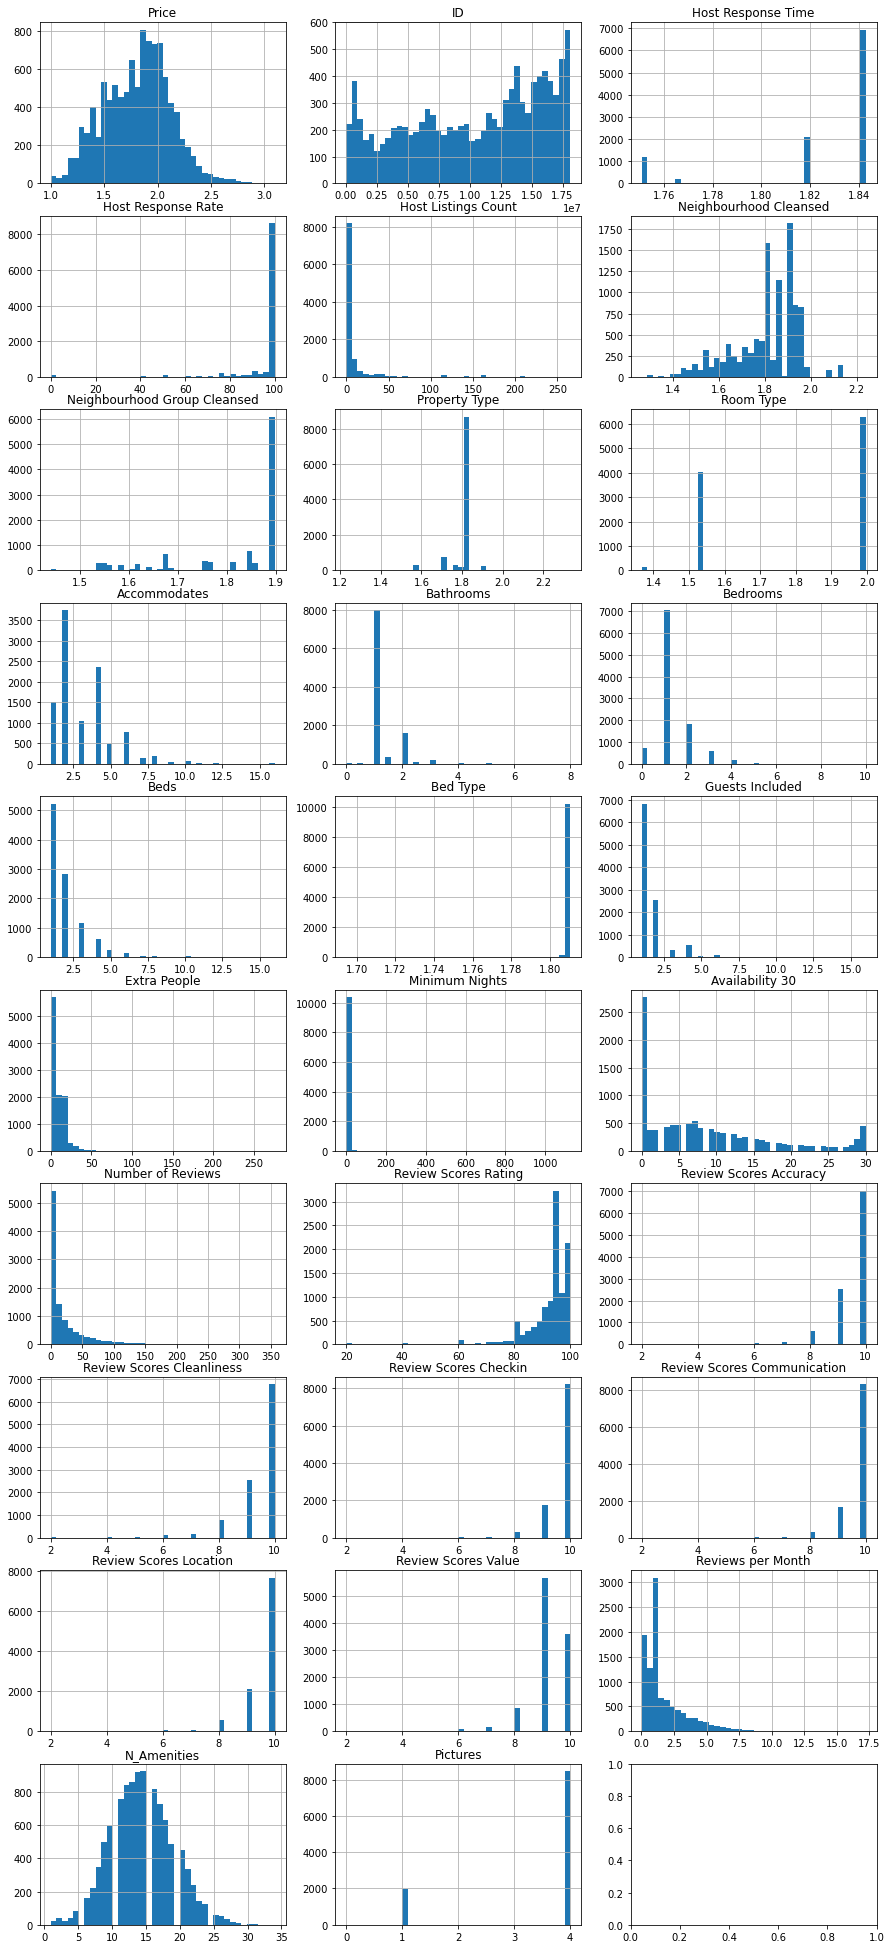

In [56]:
#Pinto los histogramas de las variables:
n_cols = 3
n_rows = math.ceil(29/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 35))
for variable, ax in zip(df.columns[:29], ax.flatten()[:29]):
    df[variable].hist(bins=40, ax=ax)
    ax.set_title(variable)
plt.show()

**Curioso histograma el las 'Amenities'.**

<b style="color: red">
**ojo!! escalas muy diferentes. Más adelante habrá que pensar ¿escalado de características?.**


**Todas las variables con cola a la izquierda las voy a transformar con los valores de su exponencial:**

In [57]:
# Transformo las variables con cola a la izquierda:
cols_to_transform = ["Host Response Time", "Host Response Rate", "Neighbourhood Cleansed", 
                     "Neighbourhood Group Cleansed", "Property Type", "Extra People", 
                     "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness", 
                     "Review Scores Checkin", "Review Scores Communication", "Review Scores Location",
                     "Review Scores Value"]
df[cols_to_transform] = df[cols_to_transform].clip(lower=0.0001) #Para evitar problemas con valores negativos o nulos
df[cols_to_transform] = df[cols_to_transform].applymap(np.exp)


**Y las variables con cola a la derecha las voy a transformar con los valores de su logaritmo:**

In [58]:
cols_to_transform = ["Host Listings Count", "Accommodates", "Bathrooms", "Bedrooms", "Beds", "Guests Included", 
                     "Extra People", "Availability 30", "Number of Reviews", "Reviews per Month"]
df[cols_to_transform] = df[cols_to_transform].clip(lower=0.0001) #Para evitar problemas con valores negativos o nulos
df[cols_to_transform] = df[cols_to_transform].applymap(np.log10)


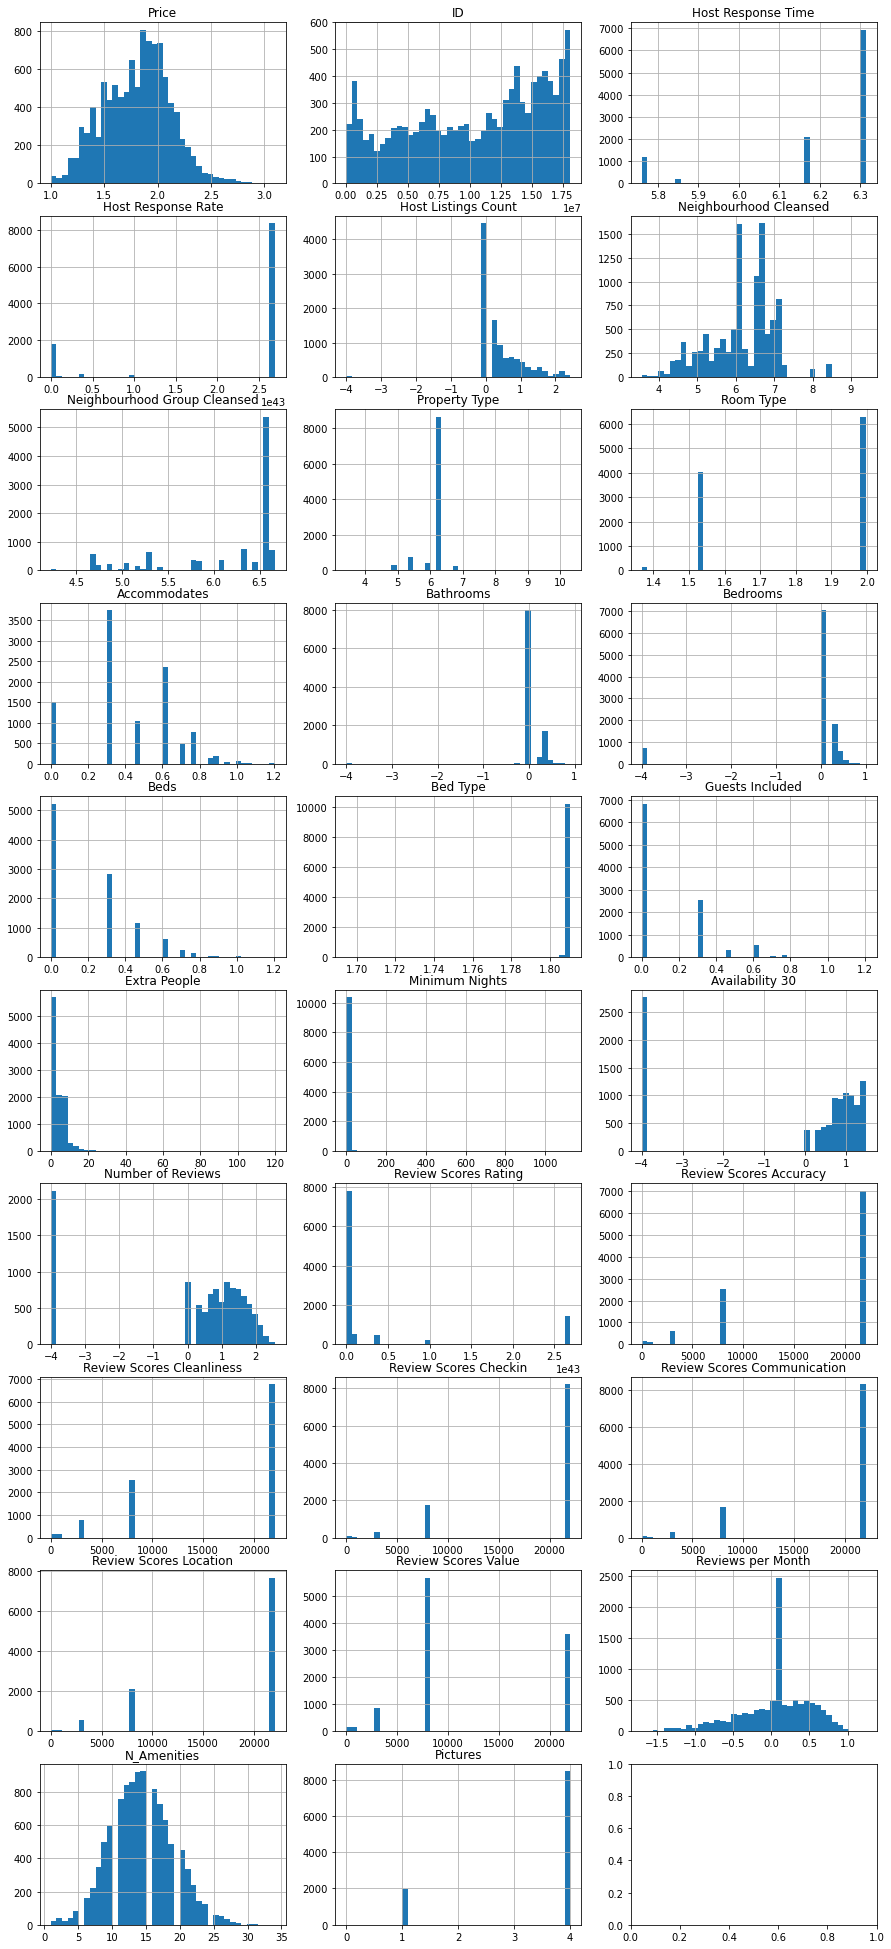

In [59]:
#Pinto de nuevo los histogramas de las variables:
n_cols = 3
n_rows = math.ceil(29/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 35))
for variable, ax in zip(df.columns[:29], ax.flatten()[:29]):
    df[variable].hist(bins=40, ax=ax)
    ax.set_title(variable)
plt.show()

**Voy a comprobar si "Pictures" es binaria pues en el histograma lo parece y como enseguida quiero hacer scatter plot necesito confirmarlo.**

In [60]:
MN_unicos = df['Pictures'].value_counts()
print(MN_unicos)

4    8458
1    1974
3      12
0       3
Name: Pictures, dtype: int64


**'Pictures' no es binaria.**

**Como no hay ninguna variable binaria, hago gráficas scatter "Price" en ordenadas y cada una de las demás variables en abscisas.**

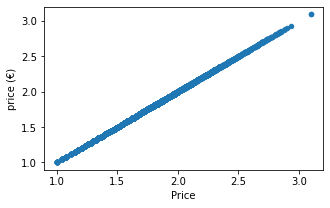

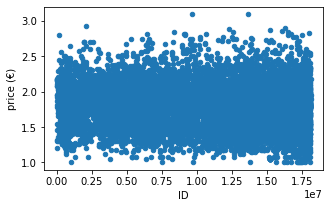

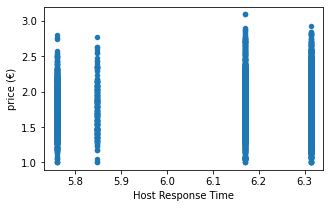

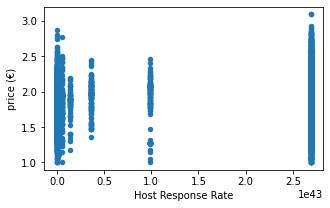

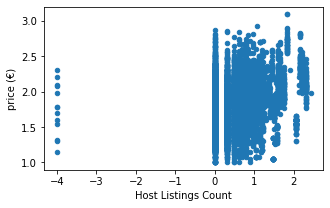

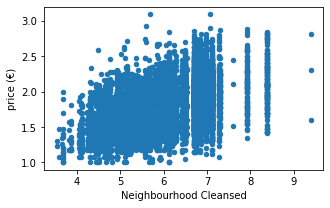

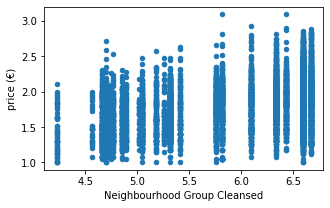

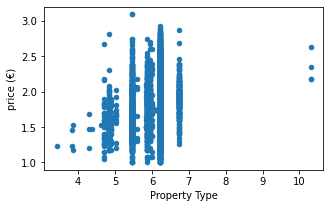

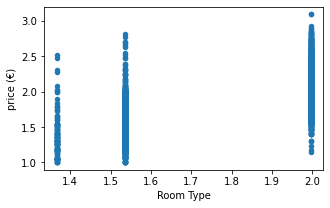

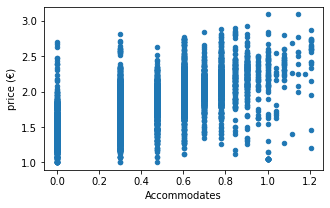

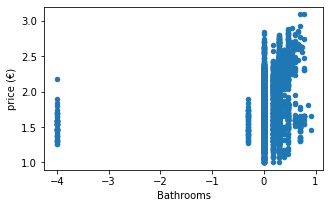

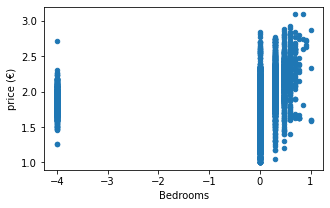

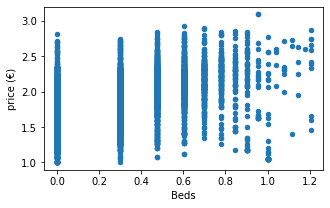

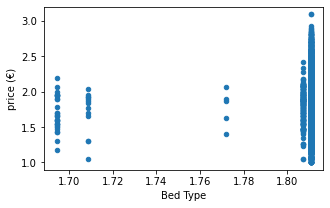

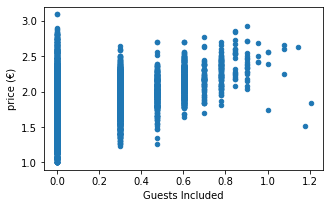

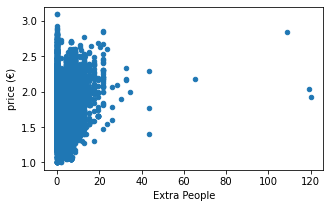

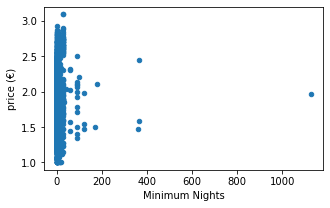

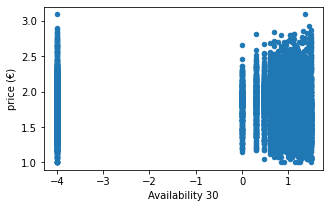

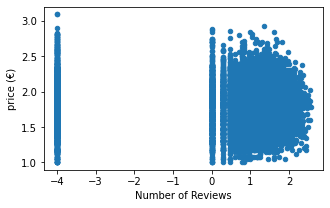

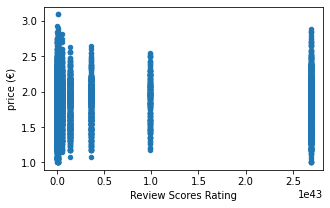

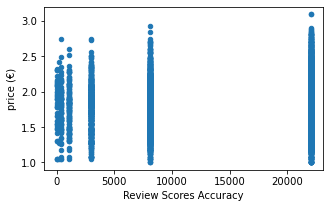

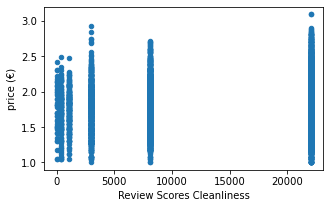

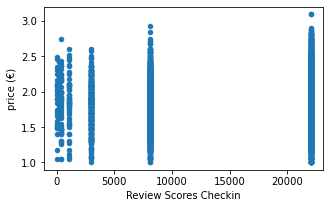

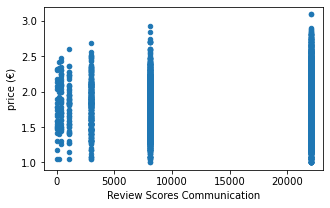

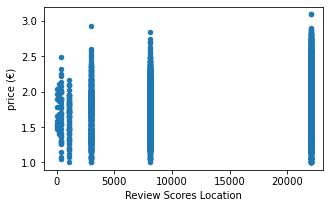

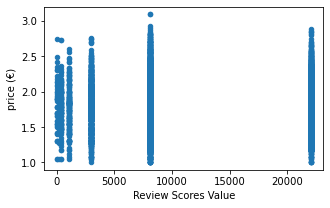

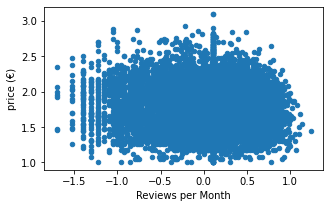

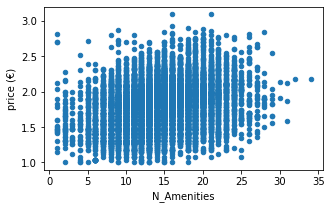

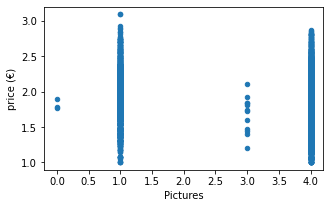

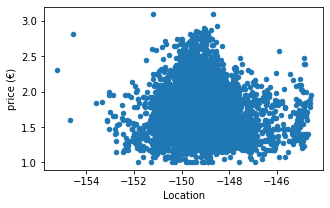

In [61]:
# Represento cada variable frente a "Price":
columnas = df.columns
plt.rcParams['figure.figsize'] = (5, 3)
for valor in columnas:
    df.plot(kind = 'scatter',x=valor,y = 'Price')
    plt.xlabel(valor)
    plt.ylabel('price (€)')
    plt.show()


**Quizá estemos viendo outliers en "Minimum Nights". Voy a mirarlo numericamente.**

In [62]:
df['Minimum Nights'].value_counts()

2       3715
1       3518
3       1739
4        424
5        351
7        265
10       117
6         80
30        67
15        51
14        23
20        20
12        10
28        10
90         9
60         5
21         4
25         4
9          4
8          4
13         3
120        3
26         2
91         2
17         2
365        2
19         1
27         1
180        1
11         1
32         1
29         1
170        1
89         1
360        1
40         1
24         1
99         1
1125       1
Name: Minimum Nights, dtype: int64

**Esta propiedad que pide una estancia mínima de 1125 noches la considero outlier y por tanto la borro.**

In [63]:
#Borro el considerado outlier Minimum Nights = 1125:
df = df.drop(df[df['Minimum Nights'] > 1000].index)

**A continuación voy a mirar la colinealidad entre variables. Fijo el umbral en 0.8, de modo que descartaré varibles que tengan correlación (en valor absoluto) por encima de ese valor.**

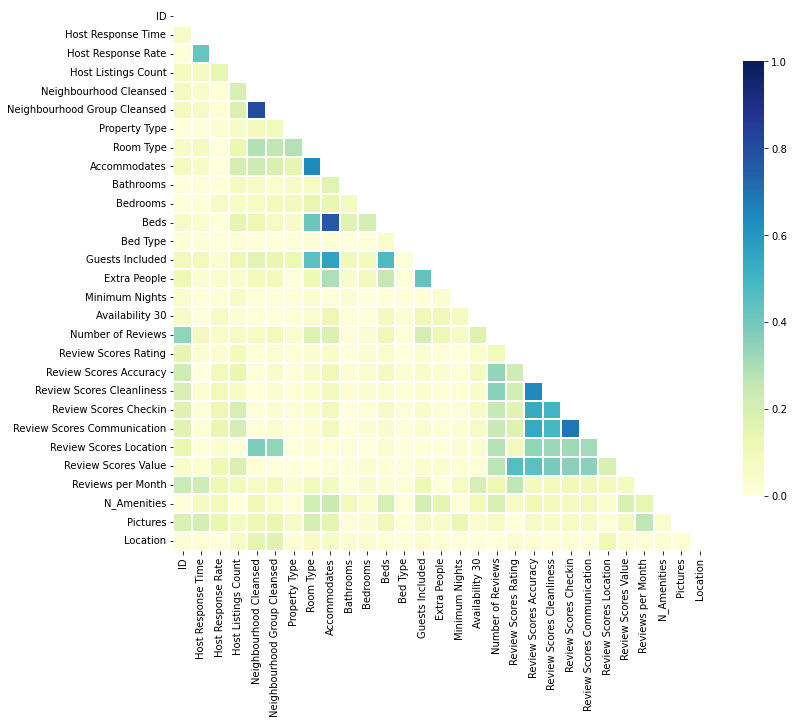

In [64]:
# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

**Las mayores correlaciones están entre Neighbourhood Cleansed y Neighbourhood Group Cleansed y ya un poco por detrás entre Beds y Accomodates.**

**Voy a verlo numericamente.**

In [65]:
# Correlación entre columnas numéricas
# Visto en https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

#tidy_corr_matrix(corr_matrix).tail(10)


variable_1                    variable_2         r  \
185  Neighbourhood Group Cleansed        Neighbourhood Cleansed  0.805682   
156        Neighbourhood Cleansed  Neighbourhood Group Cleansed  0.805682   
282                  Accommodates                          Beds  0.769444   
369                          Beds                  Accommodates  0.769444   
8                           Price                     Room Type  0.731234   
240                     Room Type                         Price  0.731234   
683         Review Scores Checkin   Review Scores Communication  0.691278   
712   Review Scores Communication         Review Scores Checkin  0.691278   
270                  Accommodates                         Price  0.673572   
9                           Price                  Accommodates  0.673572   

        abs_r  
185  0.805682  
156  0.805682  
282  0.769444  
369  0.769444  
8    0.731234  
240  0.731234  
683  0.691278  
712  0.691278  
270  0.673572  
9    0.673572

**Las mayores correlaciones entre variables están en:**
- Neighbourhood Group Cleansed y Neighbourhood Cleansed con abs_r = 0.805682
- Accommodates y Beds con abs_r = 0.769444

**Respecto al primer par, recordemos los valores ya codificados:**

In [66]:
NGC_unicos = df['Neighbourhood Group Cleansed'].value_counts()

NC_unicos = df['Neighbourhood Cleansed'].value_counts()

print(f'Valores unicos de Neighbourhood Group Cleansed:\n{NGC_unicos}', end='\n\n')
print(f'Valores unicos de Neighbourhood Cleansed:\n{NC_unicos}')

Valores unicos de Neighbourhood Group Cleansed:
6.593674    5365
6.331876     749
6.665454     710
5.315931     631
5.751730     359
6.096443     351
5.818088     327
4.656783     290
4.697919     283
6.428045     278
5.040276     243
4.848927     167
5.180176     138
4.769085     110
5.414271     109
4.742907      90
5.258699      63
4.892014      61
4.225366      59
5.011771      37
4.566423      26
Name: Neighbourhood Group Cleansed, dtype: int64

Valores unicos de Neighbourhood Cleansed:
6.131196    1464
6.501231    1044
6.748652     869
7.107867     770
6.700857     621
6.973776     597
6.854595     248
5.655796     209
5.917962     208
6.833469     186
4.924089     157
5.161536     143
5.899031     139
8.375224     138
6.723062     119
5.266601     117
5.589932     112
5.562752     110
6.247303     104
6.184826     102
5.113293      98
4.658033      90
6.413216      88
7.928237      83
6.284943      83
5.821002      74
5.169101      73
5.524841      71
7.274450      70
4.689257  

**El problema de Neighbourhood Cleansed (Barrios) es que hay muchos de tienen menos de 10 registros. Esto puede provocar que al usar luego Kfold alguna fold no contenga medidas de todas las variables y eso afecte a la calidad del modelo a la hora de generalizar.**

**Por tanto voy a borrar Neighbourhood Cleansed y me quedo con Neighbourhood Group Cleansed (Distritos).**

In [67]:
df.drop(columns=["Neighbourhood Cleansed"], inplace=True)

**Respecto al par Accommodates y Beds con abs_r = 0.769444. En este caso decido quedarme con Accomodates porque creo que tiene más que ver con el precio: en igualdad de otras condiciones, dos pisos uno con 1 cama de matrimonio puede alijar a 2 personas, mietras que si la cama es individual solo alojará (al menos en teoria) solo a una. Y sería más logico cobrar más por el alojamiento con 1 cama pero dos clientes.**

In [68]:
df.drop(columns=["Beds"], inplace=True)

In [69]:
#Mera comprobación
df.head(4).T

0             1             2  \
Price                         1.929419e+00  1.812913e+00  1.176091e+00   
ID                            5.994463e+06  1.413618e+07  1.552013e+07   
Host Response Time            6.169838e+00  6.313003e+00  6.313003e+00   
Host Response Rate            2.688117e+43  2.688117e+43  2.688117e+43   
Host Listings Count           3.010300e-01  0.000000e+00  1.204120e+00   
Neighbourhood Group Cleansed  6.096443e+00  6.593674e+00  4.697919e+00   
Property Type                 6.222759e+00  6.222759e+00  6.222759e+00   
Room Type                     1.995540e+00  1.995540e+00  1.367097e+00   
Accommodates                  6.020600e-01  6.020600e-01  0.000000e+00   
Bathrooms                     0.000000e+00  0.000000e+00  1.760913e-01   
Bedrooms                      0.000000e+00  0.000000e+00  0.000000e+00   
Bed Type                      1.810581e+00  1.810581e+00  1.810581e+00   
Guests Included               0.000000e+00  0.000000e+00  0.000000e+00   
Extra People                  4.342945e-05  4.342945e-05  4.342945e-05   
Minimum Nights                2.000000e+00  1.000000e+00  3.000000e+00   
Availability 30               9.542425e-01  1.176091e+00  1.146128e+00   
Number of Reviews             1.079181e+00  1.301030e+00 -4.000000e+00   
Review Scores Rating          1.811239e+41  3.317400e+39  6.663176e+40   
Review Scores Accuracy        8.103084e+03  8.103084e+03  2.202647e+04   
Review Scores Cleanliness     2.202647e+04  8.103084e+03  2.202647e+04   
Review Scores Checkin         2.202647e+04  2.202647e+04  2.202647e+04   
Review Scores Communication   2.202647e+04  2.202647e+04  2.202647e+04   
Review Scores Location        2.202647e+04  2.202647e+04  2.202647e+04   
Review Scores Value           8.103084e+03  2.202647e+04  8.103084e+03   
Reviews per Month            -3.010300e-01  3.856063e-01  1.105897e-01   
N_Amenities                   1.300000e+01  1.800000e+01  2.500000e+01   
Pictures                      4.000000e+00  4.000000e+00  4.000000e+00   
Location                     -1.488952e+02 -1.497543e+02 -1.510701e+02   

                                         3  
Price                         1.477121e+00  
ID                            8.809721e+06  
Host Response Time            6.169838e+00  
Host Response Rate            2.688117e+43  
Host Listings Count           2.056905e+00  
Neighbourhood Group Cleansed  6.593674e+00  
Property Type                 6.222759e+00  
Room Type                     1.535948e+00  
Accommodates                  3.010300e-01  
Bathrooms                     4.771213e-01  
Bedrooms                      0.000000e+00  
Bed Type                      1.810581e+00  
Guests Included               0.000000e+00  
Extra People                  4.342945e-05  
Minimum Nights                1.000000e+01  
Availability 30              -4.000000e+00  
Number of Reviews            -4.000000e+00  
Review Scores Rating          6.663176e+40  
Review Scores Accuracy        2.202647e+04  
Review Scores Cleanliness     2.202647e+04  
Review Scores Checkin         2.202647e+04  
Review Scores Communication   2.202647e+04  
Review Scores Location        2.202647e+04  
Review Scores Value           8.103084e+03  
Reviews per Month             1.105897e-01  
N_Amenities                   5.000000e+00  
Pictures                      4.000000e+00  
Location                     -1.496508e+02

**Y para terminar, miro la correlacion uno a uno de cada variable con 'Price':**

In [70]:
corr_matrix = df.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price                           1.000000
Room Type                       0.731234
Accommodates                    0.673572
Guests Included                 0.464901
Neighbourhood Group Cleansed    0.376748
N_Amenities                     0.287904
Host Listings Count             0.242566
Property Type                   0.185686
Extra People                    0.182702
Bathrooms                       0.164459
Review Scores Location          0.158967
Availability 30                 0.103004
Host Response Time              0.068128
Review Scores Cleanliness       0.065214
Minimum Nights                  0.054817
Bedrooms                        0.048333
Review Scores Accuracy          0.047454
Number of Reviews               0.041367
Bed Type                        0.023243
Review Scores Communication     0.017019
Review Scores Value             0.013241
Host Response Rate              0.011387
Review Scores Rating            0.007814
Review Scores Checkin           0.006554
Reviews per Mont

**Las tres variables que más correlacionan con 'Price' (en valor absoluto) son:**
  
- Room Type: 0.731234
- Accommodates: 0.673572
- Guests Included: 0.464901


In [71]:
#Las variables con las que voy a modelar son:
columnas = df.columns
print(f'Las variables con las que voy a modelar son: {columnas} \n')

#Veo la dimension del df resultante
print(f'La dimensiones del dataset de training al inicio era: {train.shape} y la dimension del df en este momento es: {df.shape}')

Las variables con las que voy a modelar son: Index(['Price', 'ID', 'Host Response Time', 'Host Response Rate',
       'Host Listings Count', 'Neighbourhood Group Cleansed', 'Property Type',
       'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Bed Type',
       'Guests Included', 'Extra People', 'Minimum Nights', 'Availability 30',
       'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per Month', 'N_Amenities', 'Pictures',
       'Location'],
      dtype='object') 

La dimensiones del dataset de training al inicio era: (11824, 89) y la dimension del df en este momento es: (10446, 28)


**He reducido en un 11% las medidas del df de training. Una reducción del 11% probablemente no tendrá un gran impacto en el rendimiento del modelo, por lo que lo dejo así por ahora al manos.**

<font color="blue">Reservo una copia de los valores de **TRAIN** en este punto.</font>

In [72]:
# ***********   ***********
# ***********   ***********

#Me guardo una copia del dataframe con los valores de train:
df_train_limpio = df.copy()

# ***********   ***********
# ***********   ***********

In [73]:
non_numeric_columns = df.select_dtypes(exclude='number')
if non_numeric_columns.empty:
    print("No hay valores no numéricos en el DataFrame.")
else:
    print("Hay valores no numéricos en las siguientes columnas:", non_numeric_columns.columns)

    

No hay valores no numéricos en el DataFrame.


<font color="red">TAREA 3. Divido el dataframe de train en X e y, hago el escalado de los datos</font>

In [74]:
# A partir del df (de train) obtengo X_train e y_train:
data = df.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, Price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)


<font color="red">TAREA 4. Replico todas las transformaciones hechas en train a los valores de test.</font>

In [75]:
# Cargo el dataset de test: 
df = pd.read_csv('./test.csv', sep=';', decimal='.')

**Operaciones hechas sobre "Price":**

In [76]:
#Muevo "Price" a la primera columna:
df = df.set_index('Price').reset_index()

#Borro Na en "Price":
df.dropna(subset=['Price'], inplace=True)

#Imputo el valor 0 a los NA de Cleaning Fee:
df["Cleaning Fee"].fillna(0, inplace=True)

#Sumo a Price el valor de Cleaning Fee y elimino Cleaning Fee:
df["Price"] = df["Price"] + df["Cleaning Fee"]
df = df.drop(["Cleaning Fee"], axis=1)

#Paso los valores a logaritmo decimal:
df['Price'] = np.log10(df['Price'])

**Borro una primera selección de columnas:**

(Eran aquellas varibles que en train tenían más del 50% de Na)

In [77]:
#Borro 'Has Availability', 'Host Acceptance Rate', 'Jurisdiction Names', 'License', 'Square Feet', 'Monthly Price', 'Weekly Price', 'Notes', 'Security Deposit':
df.drop(columns=['Has Availability', 'Host Acceptance Rate', 'Jurisdiction Names', 'License', 'Square Feet', 'Monthly Price', 'Weekly Price', 'Notes', 'Security Deposit'], inplace=True)

**Operaciones hechas sobre "City":**

In [78]:
#Muestro los valores unicos de la columna "City":
ciudades_unicas = df["City"].unique()
print(ciudades_unicas)

['Madrid' 'London' 'La Elipa' 'New York' 'Deià' 'Berlin' 'Barcelona'
 'Llucmajor' 'København' 'Amsterdam' 'Brooklyn' 'Rosebery'
 'Mal Pas-Bon Aire' 'Madrid, Comunidad de Madrid, ES' 'Campos'
 'Provensals' 'Dublin' 'Alcúdia' 'Seattle' 'Andratx' 'Washington' 'Paris'
 'Pozuelo de Alarcón' 'Los Angeles' 'Roma' 'Selva' 'Playas de Muro'
 'Chicago' 'Manacor' 'Illetes' 'Palma de Mallorca' 'Edinburgh'
 'Bondi Beach' 'Costa dels Pins' 'Campanet' 'Cala Santanyí'
 'Puerto ALCUDIA' 'Vallgornera' 'Queens' 'Inca' 'Toronto' 'Binissalem'
 'Denver' 'Santanyí' 'Porto Cristo' 'Costitx' 'Binissalem-Mallorca DO'
 '马德里' 'Calvià' 'Coogee' 'Sa Pobla' 'Málaga' 'Búger' 'Wien' 'Venice'
 'Athina' 'La Puebla' 'Son Servera' 'Palma' 'New Orleans' 'Algaida'
 'Austin' 'Hong Kong' 'Rome' 'Chueca' 'Montréal' 'Pasadena' 'Petra' nan
 'Greater London' 'Aravaca' 'Can Pastilla' 'Valldemossa' 'madrid'
 'Balearic Islands' 'Vilafranca de Bonany' 'Los Angeles County' 'Llubí'
 'Genève' 'Schaerbeek' 'Pollensa' 'Sóller' 'Colonia de 

In [79]:
# Limpio las entradas con ciudades que no son Madrid y las entradas que 
# son barrios de Madrid pero que desconozco si pueden ser también barrios de otras ciudades:

In [80]:
#Creo una máscara con lo que quiero que permanezca:
mascara = df["City"].isin(['Madrid, Comunidad de Madrid, ES', 'Chueca', 'Aravaca', 'madrid', 'Madrid, Vallecas (Fontarrón)', 'Comunidad de Madrid', 'Centro, Madrid'])

#Aplico la máscara y varío el df original:
df = df.loc[mascara].copy()

#Cambio todos los valores a "Madrid":
df.loc[:, "City"] = "Madrid"

#Ahora ya borro "City":
df.drop(columns=['City'], inplace=True)


**Operaciones hechas sobre "Amenities":**

In [81]:
#No llega la 1%. Decido borrar los Na:
df.dropna(subset=['Amenities'], inplace=True)

#Creo nueva varible N_Amenities con el nunero de comas (de "cosas") que ofrecen como 'Amenitie': 
df['N_Amenities'] = df['Amenities'].str.count(',') + 1

#Y borro 'Amenities' que ya no lo necesito:
df.drop('Amenities', axis=1, inplace=True)

**Operaciones hechas sobre "Features":**

In [82]:
#Borro 'Features':
df.drop('Features', axis=1, inplace=True)

**Operaciones hechas sobre "Scrape ID":**

In [83]:
#Borro 'Scrape ID' que ya no lo necesito:
df.drop('Scrape ID', axis=1, inplace=True)

**Operaciones hechas sobre un cierto numero de columnas:**

In [84]:
#Procedo a borrar las columnas citadas:
df.drop(columns=['Listing Url', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 'Experiences Offered', 
                 'Neighborhood Overview', 'Transit', 'Access', 'Interaction', 'House Rules', 'Host ID', 'Host URL', 
                 'Host Name', 'Host Since', 'Host Location', 'Host About', 'Host Thumbnail Url', 'Host Picture Url', 
                 'Host Neighbourhood', 'Host Total Listings Count', 'Host Verifications', 'Country Code', 'Country', 
                 'Maximum Nights', 'Calendar Updated', 'Availability 60', 'Availability 90', 'Availability 365', 
                 'Calendar last Scraped', 'Cancellation Policy', 'Calculated host listings count', 'Geolocation'], 
        inplace=True)


**Operaciones sobre "Thumbnail Url", "Medium Url", "Picture Url", "XL Picture Url":**

In [85]:
#Paso a string las columnas cuyo valor voy a cambiar:
df[["Thumbnail Url", "Medium Url", "Picture Url", "XL Picture Url"]] = df[["Thumbnail Url", "Medium Url", "Picture Url", "XL Picture Url"]].applymap(str)

for col in ['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url']:
    df[col] = df[col].apply(lambda x: 1 if x.startswith('http') else 0)
    
#Paso las columnas cambiadas a tipo entero sin signo de 8 bits:
cols = ['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url']
df[cols] = df[cols].apply(lambda x: x.astype(np.uint8))

#Nueva variable “Pictures” que me da la suma de las anteriores:
df['Pictures'] = df[['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url']].sum(axis=1)

#Borro 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url':
df.drop(columns=['Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url'], inplace=True)

**Codificación de "Room Type":**

In [86]:
#Codifico "Room Type" CON LOS VALORES DE CODIFICACIONDE TRAIN:
# {'Entire home/apt': 1.995539913662348, 'Private room': 1.5359483127726252, 'Shared room': 1.3670968167473136}
# Creo un diccionario de reemplazo con los valores de la codificacion usada en train:
diccionario = {'Entire home/apt': 1.995539913662348, 'Private room': 1.5359483127726252, 'Shared room': 1.3670968167473136}
# Mapeo para reemplazar los valores de "Room Type":
df["Room Type"] = df["Room Type"].map(diccionario)
#Miro los valores unicos de "Room Type" para ver cuáles quedan por codificar:
RT_unicos = df['Room Type'].value_counts()
print(RT_unicos)

1.535948    7
1.995540    5
Name: Room Type, dtype: int64


**Todo codificado como en train, así que sigo.**

**Codificación de "Host Response Time":**

In [87]:
#Codifico "Host Response Time" CON LOS VALORES DE CODIFICACIONDE TRAIN:
# {'a few days or more': 1.765850535702032, 'within a day': 1.750963865223261, 'within a few hours': 1.8196725192722925, 'within an hour': 1.8426114223875767}
# Creo un diccionario de reemplazo con los valores de la codificacion usada en train:
diccionario = {'a few days or more': 1.765850535702032, 'within a day': 1.750963865223261, 
               'within a few hours': 1.8196725192722925, 'within an hour': 1.8426114223875767}
# Mapeo para reemplazar los valores de "Host Response Timee":
df["Host Response Time"] = df["Host Response Time"].map(diccionario)
#Miro los valores unicos de "Host Response Time" para ver cuáles quedan por codificar:
HRT_unicos = df['Host Response Time'].value_counts()
print(HRT_unicos)

1.842611    8
1.819673    1
1.750964    1
Name: Host Response Time, dtype: int64


**Todo codificado como en train, así que sigo.**

**Codificación de "Bed Type":**

In [88]:
#Codifico "Bed Type" CON LOS VALORES DE CODIFICACIONDE TRAIN:
# {'Airbed': 1.7720076779614389, 'Couch': 1.7089377574449065, 'Futon': 1.6945132545220511, 
#'Pull-out Sofa': 1.8069710289145924, 'Real Bed': 1.8105805147829315}
# Creo un diccionario de reemplazo con los valores de la codificacion usada en train:
diccionario = {'Airbed': 1.7720076779614389, 'Couch': 1.7089377574449065, 
               'Futon': 1.6945132545220511, 'Pull-out Sofa': 1.8069710289145924, 'Real Bed': 1.8105805147829315}
# Mapeo para reemplazar los valores de "Bed Type":
df["Bed Type"] = df["Bed Type"].map(diccionario)
#Miro los valores unicos de "Host Response Time" para ver cuáles quedan por codificar:
BT_unicos = df['Bed Type'].value_counts()
print(BT_unicos)

1.810581    12
Name: Bed Type, dtype: int64


In [89]:
{'Airbed': 1.7720076779614389, 'Couch': 1.7089377574449065, 'Futon': 1.6945132545220511, 'Pull-out Sofa': 1.8069710289145924, 'Real Bed': 1.8105805147829315}

{'Airbed': 1.7720076779614389,
 'Couch': 1.7089377574449065,
 'Futon': 1.6945132545220511,
 'Pull-out Sofa': 1.8069710289145924,
 'Real Bed': 1.8105805147829315}

**Codificación de "Property Type":**

In [90]:
#Codifico "Property Type" CON LOS VALORES DE CODIFICACIONDE TRAIN:
# {'Apartment': 1.8282133663319802, 'Bed & Breakfast': 1.5769714008666866, 'Boutique hotel': 1.8116721541970062, 'Bungalow': 1.2304489213782739, 'Camper/RV': 1.4771212547196624, 'Casa particular': 1.4571457724680335, 'Chalet': 1.7939472478799394, 'Condominium': 1.7682818400153864, 'Dorm': 1.5482910804802743, 'Earth House': 1.3464234596386149, 'Guest suite': 1.3537850880489684, 'Guesthouse': 1.5861485888956464, 'Hostel': 1.6152849611925721, 'House': 1.6990683144747143, 'Loft': 1.9074188527571718, 'Other': 1.7848893777121912, 'Serviced apartment': 1.7643490357155747, 'Tent': 1.5314789170422551, 'Townhouse': 1.7217097470783873, 'Villa': 2.3320184136282887}
# Creo un diccionario de reemplazo con los valores de la codificacion usada en train:
diccionario = {'Apartment': 1.8282133663319802, 'Bed & Breakfast': 1.5769714008666866, 
               'Boutique hotel': 1.8116721541970062, 'Bungalow': 1.2304489213782739, 
               'Camper/RV': 1.4771212547196624, 'Casa particular': 1.4571457724680335, 
               'Chalet': 1.7939472478799394, 'Condominium': 1.7682818400153864, 'Dorm': 1.5482910804802743, 
               'Earth House': 1.3464234596386149, 'Guest suite': 1.3537850880489684, 
               'Guesthouse': 1.5861485888956464, 'Hostel': 1.6152849611925721, 'House': 1.6990683144747143, 
               'Loft': 1.9074188527571718, 'Other': 1.7848893777121912, 'Serviced apartment': 1.7643490357155747, 
               'Tent': 1.5314789170422551, 'Townhouse': 1.7217097470783873, 'Villa': 2.3320184136282887}
# Mapeo para reemplazar los valores de "Property Type":
df["Property Type"] = df["Property Type"].map(diccionario)
#Miro los valores unicos de "Property Type" para ver cuáles quedan por codificar:
PT_unicos = df['Property Type'].value_counts()
print(PT_unicos)

1.828213    12
Name: Property Type, dtype: int64


**Todo codificado como en train, así que sigo.**

**Más columnas que he borrado:**

In [91]:
#Elimino dichs columnas:
df.drop(columns=['Street', 'Neighbourhood', 'State', 'Zipcode', 'Market'], inplace=True)

#Elimino las columna:
df.drop(columns=['Smart Location'], inplace=True)

**Codificación de "Neighbourhood_Group_Cleansed":**

In [92]:
#Codifico "Neighbourhood_Group_Cleansed" CON LOS VALORES DE CODIFICACIONDE TRAIN:
# {'Arganzuela': 1.6707081646556896, 'Barajas': 1.659883716847344, 'Carabanchel': 1.5471195862134772, 'Centro': 1.8861107125292431, 'Chamartín': 1.8606704073002305, 'Chamberí': 1.8455965538412051, 'Ciudad Lineal': 1.617460779374855, 'Fuencarral - El Pardo': 1.6890382748124761, 'Hortaleza': 1.644838992453019, 'Latina': 1.5383248833068635, 'Moncloa - Aravaca': 1.7609716322981173, 'Moratalaz': 1.5876041744437206, 'Puente de Vallecas': 1.5787574025175646, 'Retiro': 1.8077054939666592, 'Salamanca': 1.8969381283866193, 'San Blas - Canillejas': 1.5566501710007514, 'Tetuán': 1.7495006249109415, 'Usera': 1.562154461609342, 'Vicálvaro': 1.5187302496587696, 'Villa de Vallecas': 1.6117893408431914, 'Villaverde': 1.441105786823334}
# Creo un diccionario de reemplazo con los valores de la codificacion usada en train:
diccionario = {'Arganzuela': 1.6707081646556896, 'Barajas': 1.659883716847344, 'Carabanchel': 1.5471195862134772, 
                'Centro': 1.8861107125292431, 'Chamartín': 1.8606704073002305, 'Chamberí': 1.8455965538412051,
                'Ciudad Lineal': 1.617460779374855, 'Fuencarral - El Pardo': 1.6890382748124761, 
                'Hortaleza': 1.644838992453019, 'Latina': 1.5383248833068635, 'Moncloa - Aravaca': 1.7609716322981173,
                'Moratalaz': 1.5876041744437206, 'Puente de Vallecas': 1.5787574025175646, 
                'Retiro': 1.8077054939666592, 'Salamanca': 1.8969381283866193, 
                'San Blas - Canillejas': 1.5566501710007514, 'Tetuán': 1.7495006249109415, 
                'Usera': 1.562154461609342, 'Vicálvaro': 1.5187302496587696, 'Villa de Vallecas': 1.6117893408431914,
                'Villaverde': 1.441105786823334}
# Mapeo para reemplazar los valores de "Neighbourhood_Group_Cleansed":
df["Neighbourhood Group Cleansed"] = df["Neighbourhood Group Cleansed"].map(diccionario)
#Miro los valores unicos de "Neighbourhood_Group_Cleansed" para ver cuáles quedan por codificar:
PT_unicos = df["Neighbourhood Group Cleansed"].value_counts()
print(PT_unicos)

1.886111    6
1.578757    2
1.547120    2
1.441106    1
1.760972    1
Name: Neighbourhood Group Cleansed, dtype: int64


**Todo codificado como en train, así que sigo.**

**No codifico NeighbourhoodCleansed porque luego la voy a acabar eliminando porque tenía correlación.**

**Más columnas que he borrado:**

In [93]:
#Elimino dichs columnas:
df.drop(columns=['First Review', 'Last Review'], inplace=True)

**Operaciones hechas sobre "Latitude" y "Longitude". Nueva variable "Location":**

In [94]:
#Creo la nueva variable "Location":
df['Location'] = df['Latitude'] * df['Longitude']

#Y borro "Latitude" y "Longitude":
df.drop(columns=['Latitude', 'Longitude'], inplace=True)

**Borro las filas con NaN en 'Host Listings Count', 'Bathrooms', 'Bedrooms', 'Beds':**

In [95]:
#Elimino NA en las variables 'Host Listings Count', 'Bathrooms', 'Bedrooms', 'Beds':
df.dropna(subset=['Host Listings Count', 'Bathrooms', 'Bedrooms', 'Beds'], inplace=True)

**Borro "Neighbourhood Cleansed":**

In [96]:
df.drop(columns=["Neighbourhood Cleansed"], inplace=True)

**Y los Na de 'Host Response Time', 'Host Response Rate', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'Reviews per Month', los cambio por la mediana:**

In [97]:
# Calculo la mediana de cada columna:
columnas = ['Host Response Time', 'Host Response Rate', 'Review Scores Rating', 
                   'Review Scores Accuracy', 'Review Scores Cleanliness', 
                   'Review Scores Checkin', 'Review Scores Communication', 
                   'Review Scores Location', 'Review Scores Value', 'Reviews per Month']
medianas = df[columnas].median()

# Reemplazo los valores NaN con las medianas respectivas
df[columnas] = df[columnas].fillna(medianas)

**Transformo las variables que en train tenían cola a la izquierda:**

In [98]:
# Transformo las variables con cola a la izquierda:
cols_to_transform = ["Host Response Time", "Host Response Rate",
                     "Neighbourhood Group Cleansed", "Property Type", "Extra People", 
                     "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness", 
                     "Review Scores Checkin", "Review Scores Communication", "Review Scores Location",
                     "Review Scores Value"]
df[cols_to_transform] = df[cols_to_transform].clip(lower=0.0001) #Para evitar problemas con valores negativos o nulos
df[cols_to_transform] = df[cols_to_transform].applymap(np.exp)

**Y también las variables que en train tenían cola a la derecha:**

In [99]:
# Transformo las variables con cola a la derecha:
cols_to_transform = ["Host Listings Count", "Accommodates", "Bathrooms", "Bedrooms", "Beds", "Guests Included", 
                     "Extra People", "Availability 30", "Number of Reviews", "Reviews per Month"]
df[cols_to_transform] = df[cols_to_transform].clip(lower=0.0001) #Para evitar problemas con valores negativos o nulos
df[cols_to_transform] = df[cols_to_transform].applymap(np.log10)

**Como en train eliminé una medida que catalogué como outlier respecto de la variable Minimum Nights filtrando todo lo que superara el valor 'Minimum Nights' > 1000, pues ahotra hago lo mismo con test:**

In [100]:
#Borro registros que exijan más de 1000 noches de estancia mínima:
df = df.drop(df[df['Minimum Nights'] > 1000].index)

**Las ultimas variables borradas:**

In [101]:
#Borro 'Beds':
df.drop(columns=["Beds"], inplace=True)

<font color="blue">Reservo una copia de los valores de **TEST** en este punto.</font>

In [102]:
# ***********   ***********
# ***********   ***********

#Me guardo una copia del dataframe con los valores de test:
df_test_limpio = df.copy()

# ***********   ***********
# ***********   ***********

In [103]:
non_numeric_columns = df.select_dtypes(exclude='number')
if non_numeric_columns.empty:
    print("No hay valores no numéricos en el DataFrame.")
else:
    print("Hay valores no numéricos en las siguientes columnas:", non_numeric_columns.columns)

No hay valores no numéricos en el DataFrame.


<font color="red">TAREA 5. Divido el dataframe de test en X e y, y hago el escalado de los datos usando el scaler de train.</font>

In [104]:
# A partir del df (de test) obtengo X_test e y_test:
data = df.values
y_test = data[:,0:1]     # nos quedamos con la 1ª columna, Price
X_test = data[:,1:]      # nos quedamos con el resto
feature_names = df.columns[1:]

# Escalamos (con los datos de train!!!!!)
XtestScaled = scaler.transform(X_test)


<font color="red">TAREA 6. Utilizo un modelo Lasso.</font>

In [105]:
#Grid Search:
alpha_vector = np.logspace(-6,0,20) #posibles alphas (20 números espaciados logarítmicamente entre 10^-6 y 10^0)
param_grid = {'alpha': alpha_vector}
#Lasso con cross validation de 5 divisiones:
grid = GridSearchCV(Lasso(), param_grid=param_grid, cv = KFold(n_splits=5))
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 2.06913808e-06, 4.28133240e-06, 8.85866790e-06,
       1.83298071e-05, 3.79269019e-05, 7.84759970e-05, 1.62377674e-04,
       3.35981829e-04, 6.95192796e-04, 1.43844989e-03, 2.97635144e-03,
       6.15848211e-03, 1.27427499e-02, 2.63665090e-02, 5.45559478e-02,
       1.12883789e-01, 2.33572147e-01, 4.83293024e-01, 1.00000000e+00])})

best mean cross-validation score: 0.711
best parameters: {'alpha': 7.847599703514606e-05}


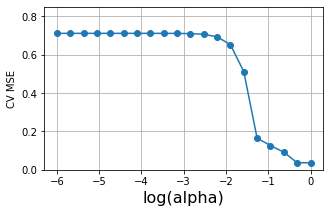

In [106]:
#Alfa optimo:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),1*scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.ylim(0, 0.85)
plt.grid()
plt.show()

In [107]:
#Lasso:
alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)

ytrainLasso = 10 ** (ytrainLasso)    # Deshago la conversion de Price a log(Price) que hice al inicio en train
ytestLasso = 10 ** (ytestLasso)      # Deshago la conversion de Price a log(Price) que hice al inicio en test

mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g\n' % mseTestModelLasso)


#Aqui hace la raiz cuadrada del error cuadrático medio, es decir, calcula el error medio que es un concepto más claro
print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g\n' % np.sqrt(mseTestModelLasso))

#Imprimo los coeficientes de las variables para el modelo Lasso ordenadas en orden decreciente de valor abosluto:
# w va multiplicadopor 100 para "hacerlo más visible"
w = lasso.coef_
w_absolutos = list(map(lambda x: abs(x), w))
indices_ordenados = sorted(range(len(w_absolutos)), key=lambda i: w_absolutos[i], reverse=True)
print("##Coeficientes de Lasso en orden decreciente de valor abosluto:")
for i in indices_ordenados:
    print(feature_names[i], w[i]*100)


#w = lasso.coef_
#for f,wi in zip(feature_names,w):
    #print(f,wi*100)

MSE Modelo Lasso (train): 7.43e+03
MSE Modelo Lasso (test) : 3.02e+03

RMSE Modelo Lasso (train): 86.2
RMSE Modelo Lasso (test) : 55

##Coeficientes de Lasso en orden decreciente de valor abosluto:
Room Type 15.406759507016341
Accommodates 8.277482692321508
Neighbourhood Group Cleansed 5.934985179209482
Reviews per Month -3.502608291972288
N_Amenities 3.352614580743238
Number of Reviews -3.341769684884957
Availability 30 2.6598080733890597
Bedrooms 2.3577336792208268
Host Listings Count 2.139317960808914
Guests Included 1.9661301421449289
Review Scores Accuracy 1.6298085128382773
Review Scores Cleanliness 1.5284886075535598
Bathrooms 1.4760931296321174
ID -1.4384675993223752
Review Scores Location 1.2666611145629458
Minimum Nights 0.8470163917149683
Host Response Time 0.5606345151214397
Extra People -0.5600325865224419
Location 0.4550177136948077
Review Scores Rating 0.38489796158556216
Property Type -0.3223852919600846
Review Scores Communication -0.2665894841243051
Pictures 0.2584412

<font color="red">TAREA 7. Comentarios y conclusiones.</font>

**Esto nos dice que usando Lasso los datos de train tienen un MSE de 7.43e+03 (RMSE de 86.2) y de 3.02e+03 (RMSE de 55) en los de train. El valor medio de Price está en torno a los 73.5 €, por lo que son valores muy elevados. El modelo funciona mejor en los datos de test que en los de train, lo cual está bien en principio, en el sentido de que no hay sobre ajuste del modelo.**

**Me resulta curioso el valor ID -1.4384675993223752 que aparece hacia la mitad. Indica una correlación moderada e inversa: a mayor valor de ID menor es el precio, lo cual no paree tener mucho sentido, pues se supone que el ID que recibe un nuevo host no depende solo de la fecha en que se da de alta (o eso al menos parece cuando miro los datos: en fechas de alta cercanas hay diversidad de valores de ID).**
    
**Igual esta variable podría ser sustituida por otra que recogiera el numero de viviendas asociadas a un mismo host (en lugar de la ID, el numero de veces que aparece ese ID). Asi veríamos si la cantidad de viviendas ofrecidas por ese host tiene relacion conn el precio.** 


**Tipo de habitación, el número de plazas y el distrito son los tres factores más influyentes. Nada que comentar de los dos primeros porque son de pura lógica. Al final el Distrito es mejor predictor que la variable que me inveté y que llamé Location (el producto de latitud por longitud) la cual aparece bastante al final del listado.**

**Una alternativa quizá mejor a la variable Location hubiera sido una variable con la distancia al metro más cercano. O con las ditancia la estacionde cercanías más cercana y/o al aeropuerto.**

**Sobre Reviews per Month (-3.502608291972288) que es la cuarta más importante en el modelo. Esta variable recoge el número promedio de reseñas que recibe la "vivienda" por mes. Pongo comillas porque sabemos que puede no ser una vivienda, textualmente hablando. Puede ser una habitación o incluso una cama en habitacion compartida. Un valor alto de reseñas sugiere por un lado una mayor rotación y por otro lado un alto nivel de ocupación. Y, de ser así esta explicación, más rotacion y más ocupacion habla en mi opinión más de perfiles de alojamiento más de "paso la noche con lo mínimo que esté bien y listo" lo cual cuadraría con que la correlacione con precio es negativa. Sitios de mucha rotacion y mucha ocupacion tendrían menor precio, puede tener su lógica.** 

**La quinta más influyente es la variable N_Amenities (3.352614580743238). Es una columna calculada que recoge el número de cosas que se ofrecen en Ammenities. No qué cosas en concreto sino cuántas cosas. Visto que esta variable tiene potencial, en futuras mejoras lo que se me ocurre es transformara para actúe a modo de "clasificador" de forma recoja lo "exclusivas" que son las ammenities que se ofrecen. Por ejemplo, si el 95% ofrecen como ammenitie la red wifi, y el 5% ofrece como ammnitie un ticket del bus turístico gratis a cada persona alojada, pues que a la hora de contar lo que ofrece esa vivienda no sume igual la presencia de una cosa que la de otra. En el modelo actual cualquier cosa sea o no exclusiva suma un punto al valor de esa variable. En el modelo que propongo sumaría más el ticket que la wifi a esa variable.**

NOTA PARA MI: esto se puede montar con diccionarios que recojan las amenities por cada propiedad. Hacer un conteo del nuemro de veces que aparece cada amenitie en el total de viendas y luego asignar valores por ejemplo por cuartiles (ammenitiees que solo están en el 25% de las casas reciben por ejemplo 8 puntos, las que están en el 50% reciben 4, las que están en el 75% reciben 2 y el resto reciben 1 ....).

**De Number of Reviews -3.341769684884957 haría un análisis similar al de Reviews per Month. Lo curioso es que en el análisis de los datos en train no se identificaba alta correlacion entre anmbas variables a pesar de lo que pudiera parecer intuitivamente.** 

**Sobre Availability 30: 2.6598080733890597. Pare lógico que esté entre las más influyentes en el modelo porque parece intuitivamente lógico lo quen nos dice: hay relación directa entre la disponibilidad y el precio. Y aquí en mi opnión tendría sentido entrar a un análisis de causalidad y no solo de correlación. ¿Es un precio alto la causa de una alta disponibilidad?. La teoría de la oferta y la demanda dice que sí, pero....** 

<font color="red">TAREA 8. Utilizo un modelo Ridge.</font>

In [108]:
#Grid Search:
alpha_vector = np.logspace(-1,7,20) #posibles alphas (20 números espaciados logarítmicamente entre 10^-6 y 10^0)
param_grid = {'alpha': alpha_vector}
#Ridge con cross validation de 5 divisiones:
grid = GridSearchCV(Ridge(), param_grid=param_grid, cv = KFold(n_splits=5))
grid.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-01, 2.63665090e-01, 6.95192796e-01, 1.83298071e+00,
       4.83293024e+00, 1.27427499e+01, 3.35981829e+01, 8.85866790e+01,
       2.33572147e+02, 6.15848211e+02, 1.62377674e+03, 4.28133240e+03,
       1.12883789e+04, 2.97635144e+04, 7.84759970e+04, 2.06913808e+05,
       5.45559478e+05, 1.43844989e+06, 3.79269019e+06, 1.00000000e+07])})

best mean cross-validation score: 0.711
best parameters: {'alpha': 1.8329807108324356}


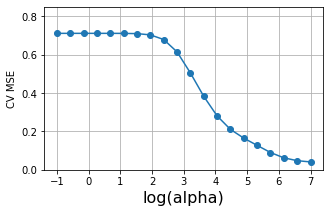

In [109]:
#Alfa optimo:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),1*scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.ylim(0, 0.85)
plt.grid()
plt.show()

In [110]:
#Ridge:
alpha_optimo = grid.best_params_['alpha']
ridge = Ridge(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainRidge = ridge.predict(XtrainScaled)
ytestRidge  = ridge.predict(XtestScaled)

ytrainRidge = 10 ** (ytrainRidge)    # Deshago la conversion de Price a log(Price) que hice al inicio en train
ytestRidge = 10 ** (ytestRidge)      # Deshago la conversion de Price a log(Price) que hice al inicio en test

mseTrainModelRidge = mean_squared_error(y_train,ytrainRidge)
mseTestModelRidge = mean_squared_error(y_test,ytestRidge)

print('MSE Modelo Ridge (train): %0.3g' % mseTrainModelRidge)
print('MSE Modelo Ridge (test) : %0.3g\n' % mseTestModelRidge)


#Aqui hace la raiz cuadrada del error cuadrático medio, es decir, calcula el error medio que es un concepto más claro
print('RMSE Modelo Ridge (train): %0.3g' % np.sqrt(mseTrainModelRidge))
print('RMSE Modelo Ridge (test) : %0.3g\n' % np.sqrt(mseTestModelRidge))

#Imprimo los coeficientes de las variables para el modelo Ridge ordenadas en orden decreciente de valor abosluto:
# w va multiplicadopor 100 para "hacerlo más visible"
#w = ridge.coef_
w= ridge.coef_[0]
w_absolutos = list(map(lambda x: abs(x), w))
indices_ordenados = sorted(range(len(w_absolutos)), key=lambda i: w_absolutos[i], reverse=True)
print("##Coeficientes de Ridge en orden decreciente de valor abosluto:")
for i in indices_ordenados:
    print(feature_names[i], w[i]*100)


MSE Modelo Ridge (train): 7.44e+03
MSE Modelo Ridge (test) : 3.02e+03

RMSE Modelo Ridge (train): 86.2
RMSE Modelo Ridge (test) : 54.9

##Coeficientes de Ridge en orden decreciente de valor abosluto:
Room Type 15.411983579827806
Accommodates 8.279403905491133
Neighbourhood Group Cleansed 5.943829494365624
Reviews per Month -3.510810913379098
N_Amenities 3.3592089963271876
Number of Reviews -3.3495826191468896
Availability 30 2.67273011592165
Bedrooms 2.363881935155403
Host Listings Count 2.140934525820634
Guests Included 1.9767903108299667
Review Scores Accuracy 1.6430063834284563
Review Scores Cleanliness 1.5337829230519078
Bathrooms 1.4808432190520158
ID -1.455017466545925
Review Scores Location 1.2711281025776136
Minimum Nights 0.8547082122765859
Extra People -0.5760108270002857
Host Response Time 0.5653937533565512
Location 0.4644643105328423
Review Scores Rating 0.400499957172503
Property Type -0.3311196318853158
Review Scores Communication -0.2962283277472483
Review Scores Value 

<font color="red">TAREA 9. Pruebo un modelo ElasticNet:.</font>

In [111]:
#Grid Search:
alpha_vector = np.logspace(-10,7,20) #posibles alphas (20 números espaciados logarítmicamente entre 10^-6 y 10^0)
param_grid = {'alpha': alpha_vector}
#ElasticNet con cross validation de 5 divisiones:
grid = GridSearchCV(ElasticNet(), param_grid=param_grid, cv = KFold(n_splits=5))
grid.fit(X_train, y_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-10, 7.84759970e-10, 6.15848211e-09, 4.83293024e-08,
       3.79269019e-07, 2.97635144e-06, 2.33572147e-05, 1.83298071e-04,
       1.43844989e-03, 1.12883789e-02, 8.85866790e-02, 6.95192796e-01,
       5.45559478e+00, 4.28133240e+01, 3.35981829e+02, 2.63665090e+03,
       2.06913808e+04, 1.62377674e+05, 1.27427499e+06, 1.00000000e+07])})

best mean cross-validation score: 0.711
best parameters: {'alpha': 0.00018329807108324376}


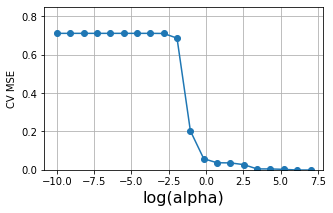

In [112]:
#Alfa optimo:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(alpha_vector),1*scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(alpha)',fontsize=16)
plt.ylabel('CV MSE')
plt.ylim(0, 0.85)
plt.grid()
plt.show()

In [113]:
#ElasticNet:
alpha_optimo = grid.best_params_['alpha']
elasticNet = ElasticNet(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainElasticNet = elasticNet.predict(XtrainScaled)
ytestElasticNet  = elasticNet.predict(XtestScaled)

ytrainElasticNet = 10 ** (ytrainElasticNet)    # Deshago la conversion de Price a log(Price) que hice al inicio en train
ytestElasticNet = 10 ** (ytestElasticNet)      # Deshago la conversion de Price a log(Price) que hice al inicio en test

mseTrainModelElasticNet = mean_squared_error(y_train,ytrainElasticNet)
mseTestModelElasticNet = mean_squared_error(y_test,ytestElasticNet)

print('MSE Modelo ElasticNet (train): %0.3g' % mseTrainModelElasticNet)
print('MSE Modelo ElasticNet (test) : %0.3g\n' % mseTestModelElasticNet)


#Aqui hace la raiz cuadrada del error cuadrático medio, es decir, calcula el error medio que es un concepto más claro
print('RMSE Modelo ElasticNet (train): %0.3g' % np.sqrt(mseTrainModelElasticNet))
print('RMSE Modelo ElasticNet (test) : %0.3g\n' % np.sqrt(mseTestModelElasticNet))

#Imprimo los coeficientes de las variables para el modelo ElasticNet ordenadas en orden decreciente de valor abosluto:
# w va multiplicadopor 100 para "hacerlo más visible"
w= elasticNet.coef_
w_absolutos = list(map(lambda x: abs(x), w))
indices_ordenados = sorted(range(len(w_absolutos)), key=lambda i: w_absolutos[i], reverse=True)
print("##Coeficientes de Ridge en orden decreciente de valor abosluto:")
for i in indices_ordenados:
    print(feature_names[i], w[i]*100)


MSE Modelo ElasticNet (train): 7.43e+03
MSE Modelo ElasticNet (test) : 3.02e+03

RMSE Modelo ElasticNet (train): 86.2
RMSE Modelo ElasticNet (test) : 55

##Coeficientes de Ridge en orden decreciente de valor abosluto:
Room Type 15.4031099730602
Accommodates 8.277364036882904
Neighbourhood Group Cleansed 5.93284896609891
Reviews per Month -3.5005318400030663
N_Amenities 3.3513688255150185
Number of Reviews -3.339257909383439
Availability 30 2.657051501665186
Bedrooms 2.3560244872218785
Host Listings Count 2.139145193007442
Guests Included 1.9650429480500289
Review Scores Accuracy 1.627562071674851
Review Scores Cleanliness 1.5276588956253592
Bathrooms 1.475259301940235
ID -1.4352911156733783
Review Scores Location 1.2661997247767371
Minimum Nights 0.8456831056909805
Host Response Time 0.5598247360448451
Extra People -0.5572775540556196
Location 0.45319643953588934
Review Scores Rating 0.3823116012328434
Property Type -0.32036615732817647
Review Scores Communication -0.2613719688478137
P

**Lo que compruebo es que tanto Lasso, como Ridge como ElasticNet proporcionan valores de RMSE similares.**

<font color="red">**A PARTIR DE AQUÍ QUIERO IMPLEMENTAR ARBOL DE DECISION, RANDOM FOREST Y BAGGING. PERO ES DONIDE ME ENCUENTRO CON QUE X_train Y/O y_train ME DAN PROBLEMAS.***</font>

In [114]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)


print(X_train[1])
print("\n")
print(y_train)

[ 1.4136180e+07  6.3130026e+00            inf  0.0000000e+00
  6.5936742e+00  6.2227588e+00  1.9955399e+00  6.0206002e-01
  0.0000000e+00  0.0000000e+00  1.8105805e+00  0.0000000e+00
  4.3429449e-05  1.0000000e+00  1.1760913e+00  1.3010300e+00
            inf  8.1030840e+03  8.1030840e+03  2.2026465e+04
  2.2026465e+04  2.2026465e+04  2.2026465e+04  3.8560626e-01
  1.8000000e+01  4.0000000e+00 -1.4975430e+02]


[[1.9294189]
 [1.8129133]
 [1.1760913]
 ...
 [1.9956352]
 [1.9731278]
 [1.39794  ]]


In [115]:
print("Valores infinitos en X_train:", np.isinf(X_train).sum())
print("Valores infinitos en y_train:", np.isinf(y_train).sum())


Valores infinitos en X_train: 17765
Valores infinitos en y_train: 0


**A continuación voy a implementar un arbol de regresión.**

In [116]:
#Verifico X_train
non_numeric_X_train = ~np.isreal(X_train)
if non_numeric_X_train.any():
    print("Hay valores no numéricos en X_train")
else:
    print("No hay valores no numéricos en X_train")

#Verifico y_train
non_numeric_y_train = ~np.isreal(y_train)
if non_numeric_y_train.any():
    print("Hay valores no numéricos en y_train")
else:
    print("No hay valores no numéricos en y_train")


No hay valores no numéricos en X_train
No hay valores no numéricos en y_train


In [117]:
print("Valores NaN en X_train:", np.isnan(X_train).sum())
print("Valores Nan en y_train:", np.isnan(y_train).sum())


Valores NaN en X_train: 0
Valores Nan en y_train: 0


In [118]:
# DecisionTreeRegressor
maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid=param_grid, cv = 10, verbose=1)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

Fitting 10 folds for each of 14 candidates, totalling 140 fits


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
maxDepthOptimo = grid.best_params_['max_depth'] 
treeModel = DecisionTreeRegressor(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))

**Voy a mirar cuáles serían las variables más importantes, según este modelo.**

In [ ]:
importances = treeModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(5,5))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

tree_dot = export_graphviz(treeModel, out_file=None, feature_names=feature_names,  
                         filled=True, rounded=True,  special_characters=True)
graph = graphviz.Source(tree_dot) 
graph

**No logro que graphviz se cargue bien ...**

**Hago un Random Forest:**

In [ ]:
maxDepth = range(1,25)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=5, verbose=2) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

**Idéntico a lo que ocurría con el árbol de decisión.**

In [ ]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

In [ ]:
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(3,3))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

**Finalmente pruebo un Bagging Regressor (con muy poca esperanza la verdad, jeje):**

In [119]:
maxDepth = range(1,15)
tuned_parameters = {'base_estimator__max_depth': maxDepth}

grid = GridSearchCV(BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=0, n_estimators=200), param_grid=tuned_parameters,cv=5, verbose=2) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ........................base_estimator__max_depth=1; total time=   0.0s
[CV] END ........................base_estimator__max_depth=1; total time=   0.0s
[CV] END ........................base_estimator__max_depth=1; total time=   0.0s
[CV] END ........................base_estimator__max_depth=1; total time=   0.0s
[CV] END ........................base_estimator__max_depth=1; total time=   0.0s
[CV] END ........................base_estimator__max_depth=2; total time=   0.0s
[CV] END ........................base_estimator__max_depth=2; total time=   0.0s
[CV] END ........................base_estimator__max_depth=2; total time=   0.0s
[CV] END ........................base_estimator__max_depth=2; total time=   0.0s
[CV] END ........................base_estimator__max_depth=2; total time=   0.0s
[CV] END ........................base_estimator__max_depth=3; total time=   0.0s
[CV] END ........................base_estimator_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').